In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads
from shapely.geometry import Polygon
from shapely.ops import unary_union
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.spatial import cKDTree
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split


In [2]:
event_df = gpd.read_file("event_df_middelhav.shp")
df_monthly = pd.read_csv("df_summary_monthly_middelhav.csv")


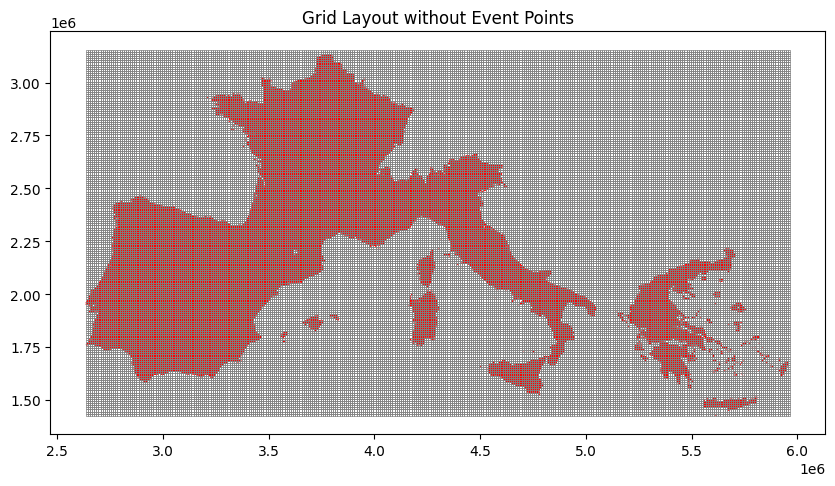

In [22]:
# import geopandas as gpd
# import numpy as np
# from shapely.geometry import box
# import matplotlib.pyplot as plt

# # Make sure the GeoDataFrame has correct CRS
# gdf = gpd.GeoDataFrame(event_df.copy(), geometry='geometry')
# gdf = gdf.to_crs(epsg=3035)

# # Define grid size (e.g., 10 km x 10 km)
# grid_size = 10000  # in meters

# # Get bounds of all geometries
# xmin, ymin, xmax, ymax = gdf.total_bounds

# # Create grid cells covering the bounding box
# cols = np.arange(xmin, xmax + grid_size, grid_size)
# rows = np.arange(ymin, ymax + grid_size, grid_size)
# grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in cols for y in rows]

# grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)

# # Compute centroids of events for spatial join
# gdf["centroid"] = gdf.geometry.centroid
# gdf_centroids = gdf.set_geometry("centroid")

# # Spatial join: assign each centroid to a grid cell
# joined = gpd.sjoin(gdf_centroids, grid, how="left", predicate="within")
# joined = joined.rename(columns={'index_right': 'grid_id'})

# # Add grid ID to original GeoDataFrame
# gdf["grid_id"] = joined["grid_id"]

# # Optional: visualize
# fig, ax = plt.subplots(figsize=(10, 10))
# grid.boundary.plot(ax=ax, linewidth=0.5, color='gray')
# gdf.geometry.plot(ax=ax, color='red', markersize=2)
# plt.title("Grid Layout without Event Points")
# plt.show()


In [3]:
event_df = event_df.sort_values(["id", "start_time"]).copy()

def fix_no_prior_fire(group):
    """
    For each grid (group), the first row is set to no_prior_fire=1.
    If we have already seen a fire in earlier rows, then no_prior_fire=0 for subsequent rows.
    """
    has_seen_fire = False
    for i in group.index:
        if i == group.index[0]:
            # first row in this grid
            group.loc[i, "no_prior_fire"] = 1
        else:
            # subsequent rows
            group.loc[i, "no_prior_fire"] = 0 if has_seen_fire else 1

        # If this row has a fire, update flag
        if group.loc[i, "fire_occur"] == 1:
            has_seen_fire = True
    return group

# Apply the logic per grid (grouped by 'id')
event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)

# (Optional) re-sort or reset index if you wish
event_df = event_df.sort_values(["id", "start_time"]).reset_index(drop=True)

C:\Users\hclt0\AppData\Local\Temp\ipykernel_48348\3054020803.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)


In [4]:
# 1) Make sure your DataFrame is sorted by id & time
event_df = event_df.sort_values(['id', 'start_time'])

# 2) Pull in the previous stop_time per id
event_df['prev_stop_time'] = (
    event_df
    .groupby('id')['stop_time']
    .shift(1)
)

# 3) Define your “true” start_time: 
#    if this is the first fire for that id, keep the original start_time;
#    otherwise use prev_stop_time exactly (no +1)
event_df['true_start_time'] = event_df['prev_stop_time'].fillna(event_df['start_time'])

# 4) Recompute duration
event_df['duration'] = event_df['stop_time'] - event_df['true_start_time']

# 5) (Optional) if you also keep the old start for reference:
#    rename the columns accordingly
event_df = event_df.rename(columns={
    'start_time': 'raw_start_time',
    'true_start_time': 'start_time'
})

print(event_df[["id", "start_time", "stop_time", "fire_occur"]].head(20))

         id  start_time  stop_time  fire_occur
0   37297.0         0.0        178           0
1   37297.0       178.0       4585           0
2   37297.0      4585.0       5843           0
3   37298.0         0.0        381           0
4   37298.0       381.0       3932           1
5   37298.0      3932.0       5263           0
6   37298.0      5263.0       5685           1
7   37298.0      5685.0       5843           0
8   37299.0         0.0        742           0
9   37299.0       742.0       3932           1
10  37299.0      3932.0       4753           0
11  37299.0      4753.0       5685           1
12  37299.0      5685.0       5843           0
13  37317.0         0.0       1497           0
14  37317.0      1497.0       1583           0
15  37317.0      1583.0       5843           0
16  37318.0         0.0       2409           0
17  37318.0      2409.0       2443           0
18  37318.0      2443.0       5843           0
19  37511.0         0.0        502           0


In [23]:
print(event_df[["id", "start_time", "stop_time", "fire_occur", "days_since_last_fire"]].head(20))

         id  start_time  stop_time  fire_occur  days_since_last_fire
0   37297.0           0      178.0           0                     1
1   37297.0         179     4585.0           0                     1
2   37297.0        4586     5843.0           0                     1
3   37298.0           0      381.0           0                     1
4   37298.0         382     3932.0           1                     1
5   37298.0        3933     5263.0           0                  1331
6   37298.0        5264     5685.0           1                  1753
7   37298.0        5686     5843.0           0                   158
8   37299.0           0      742.0           0                     1
9   37299.0         743     3932.0           1                     1
10  37299.0        3933     4753.0           0                   821
11  37299.0        4754     5685.0           1                  1753
12  37299.0        5686     5843.0           0                   158
13  37317.0           0     1497.0

In [67]:
# test_df = event_df[:1000].copy()

# def compute_days_since_fire(group):
#     group = group.sort_values("start_dt").copy()
#     last_fire_stop = None
#     days_list = []

#     for _, row in group.iterrows():
#         if last_fire_stop is None:
#             # First event: days is 1 if no prior fire, else 0
#             days = 1 if row["no_prior_fire"] == 1 else 0
#         else:
#             # For both fire and non-fire events, use stop_dt to compute days
#             days = (row["stop_dt"] - last_fire_stop).days

#         days_list.append(days)

#         # Update last_fire_stop only if the current row is a fire
#         if row["fire_occur"] == 1:
#             last_fire_stop = row["stop_dt"]

#     group["days_since_last_fire"] = days_list
#     return group
# df = (
#     test_df
#       .sort_values(["id", "start_dt"])
#       .groupby("id", group_keys=False)
#       .apply(compute_days_since_fire)
#       .reset_index(drop=True)
# )

# print(df[[
#     "id", "stop_time", "fire_occur",
#     "days_since_last_fire", "no_prior_fire"
# ]].head(30))

         id  stop_time  fire_occur  days_since_last_fire  no_prior_fire
0   37297.0        178           0                     1            1.0
1   37297.0       4585           0                     1            1.0
2   37297.0       5843           0                     1            1.0
3   37298.0       3747           0                     1            1.0
4   37298.0       3840           0                     1            1.0
5   37298.0       3932           1                     1            1.0
6   37298.0       5685           1                  1753            0.0
7   37298.0       5843           0                   158            0.0
8   37299.0       3296           0                     1            1.0
9   37299.0       3932           1                     1            1.0
10  37299.0       4429           0                   497            0.0
11  37299.0       5685           1                  1753            0.0
12  37299.0       5843           0                   158        

C:\Users\hclt0\AppData\Local\Temp\ipykernel_26888\1096769550.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df


In [5]:
def compute_days_since_fire(group):
    group = group.sort_values("start_dt").copy()
    last_fire_stop = None
    days_list = []

    for _, row in group.iterrows():
        if last_fire_stop is None:
            # First event: days is 1 if no prior fire, else 0
            days = 1 if row["no_prior_fire"] == 1 else 0
        else:
            # For both fire and non-fire events, use stop_dt to compute days
            days = (row["stop_dt"] - last_fire_stop).days

        days_list.append(days)

        # Update last_fire_stop only if the current row is a fire
        if row["fire_occur"] == 1:
            last_fire_stop = row["stop_dt"]

    group["days_since_last_fire"] = days_list
    return group

# Apply the function
df = (
    event_df.sort_values(["id", "start_dt"])
    .groupby("id", group_keys=False)
    .apply(compute_days_since_fire)
    .reset_index(drop=True)
)

# no_prior_fire stays the same
no_fire_map = df.groupby("id")["fire_occur"].max().apply(lambda x: 0 if x==1 else 1)
df["no_prior_fire"] = df["id"].map(no_fire_map)

event_df = df

event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)
event_df["days_since_last_fire"] = event_df["days_since_last_fire"].replace(0, 1)
print(event_df[[
    "id", "stop_time", "fire_occur",
    "days_since_last_fire", "no_prior_fire"
]].head(30))

C:\Users\hclt0\AppData\Local\Temp\ipykernel_48348\3590277647.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df.sort_values(["id", "start_dt"])


         id  stop_time  fire_occur  days_since_last_fire  no_prior_fire
0   37297.0        178           0                     1              1
1   37297.0       4585           0                     1              1
2   37297.0       5843           0                     1              1
3   37298.0        381           0                     1              1
4   37298.0       3932           1                     1              1
5   37298.0       5263           0                  1331              0
6   37298.0       5685           1                  1753              0
7   37298.0       5843           0                   158              0
8   37299.0        742           0                     1              1
9   37299.0       3932           1                     1              1
10  37299.0       4753           0                   821              0
11  37299.0       5685           1                  1753              0
12  37299.0       5843           0                   158        

C:\Users\hclt0\AppData\Local\Temp\ipykernel_48348\3590277647.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)


In [6]:
# assuming your full dataset is in `df_model` (or replace with the appropriate DataFrame)

# 1) build the mask
leak_mask = event_df["days_since_last_fire"] == event_df["duration"]

# 2) total number of “leaky” rows
n_leak = leak_mask.sum()
print(f"Number of rows where days_since_last_fire == duration: {n_leak}")

# 3) breakdown of fire_occurred_x in those rows
vc = event_df.loc[leak_mask, "fire_occur"].value_counts().sort_index()
print("fire_occurred_x value counts among those rows:")
print(vc)


Number of rows where days_since_last_fire == duration: 22181
fire_occurred_x value counts among those rows:
fire_occur
0    19356
1     2825
Name: count, dtype: int64


In [22]:
# assuming your full dataset is in `df_model` (or replace with the appropriate DataFrame)

# 1) build the mask
leak_mask = df_reduced["days_since_last_fire"] == df_reduced['duration']

# 2) total number of “leaky” rows
n_leak = leak_mask.sum()
print(f"Number of rows where days_since_last_fire == duration: {n_leak}")

# 3) breakdown of fire_occurred_x in those rows
vc = df_reduced.loc[leak_mask, "fire_occur"].value_counts().sort_index()
print("fire_occurred_x value counts among those rows:")
print(vc)
leak_mask = df_reduced["days_since_last_fire"] == 1

# 2) total number of “leaky” rows
n_leak = leak_mask.sum()
print(f"Number of rows where days_since_last_fire == 1: {n_leak}")

# 3) breakdown of fire_occurred_x in those rows
vc = df_reduced.loc[leak_mask, "fire_occur"].value_counts().sort_index()
print("fire_occurred_x value counts among those rows:")
print(vc)



Number of rows where days_since_last_fire == duration: 15315
fire_occurred_x value counts among those rows:
fire_occur
0    6574
1    8741
Name: count, dtype: int64
Number of rows where days_since_last_fire == 1: 33592
fire_occurred_x value counts among those rows:
fire_occur
0    28169
1     5423
Name: count, dtype: int64


In [31]:
df_reduced

,level_0,id,start_dt,stop_dt,fire_occur,raw_start_time,stop_time,stop_date,sin_month,cos_month,...,grassland,other,south,geometry,no_prior_fire,prev_stop_time,start_time,duration,days_since_last_fire,to_squash
0,0,37297.0,2008-06-28,2020-07-21,0,179,4585,2020-07-21,-0.500000,-0.866025,...,0.00000,0.03222,0.189219,"POLYGON ((2643879.2704 1965289.0014, 2640140.2...",1,178.0,0.0,4585.0,1,False
1,1,37297.0,2020-07-22,2023-12-31,0,4586,5843,2023-12-31,-0.000000,1.000000,...,0.00000,0.03222,0.189219,"POLYGON ((2643879.2704 1965289.0014, 2640140.2...",1,4585.0,4585.0,1258.0,1,False
2,3,37298.0,2009-01-17,2018-10-07,1,382,3932,2018-10-07,-0.866025,0.500000,...,0.02171,0.00937,0.363963,"POLYGON ((2643879.2704 1955289.0014, 2637571.4...",1,381.0,0.0,3932.0,1,True
3,5,37298.0,2022-05-31,2023-07-26,1,5264,5685,2023-07-26,-0.500000,-0.866025,...,0.02171,0.00937,0.363963,"POLYGON ((2643879.2704 1955289.0014, 2637571.4...",0,5263.0,3932.0,1753.0,1753,True
4,6,37298.0,2023-07-27,2023-12-31,0,5686,5843,2023-12-31,-0.000000,1.000000,...,0.02171,0.00937,0.363963,"POLYGON ((2643879.2704 1955289.0014, 2637571.4...",0,5685.0,5685.0,158.0,158,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55800,71648,110150.0,2022-04-22,2023-12-31,0,5225,5843,2023-12-31,-0.000000,1.000000,...,0.36575,0.06011,0.347073,"POLYGON ((5948686.5964 1639501.4667000007, 594...",1,5224.0,5224.0,619.0,1,False
55801,71649,110366.0,2018-04-14,2019-12-18,0,3756,4369,2019-12-18,-0.000000,1.000000,...,0.00000,0.05607,0.052189,"POLYGON ((5953879.2704 1675289.0014, 5953879.2...",1,3755.0,0.0,4369.0,1,False
55802,71650,110366.0,2019-12-19,2023-12-31,0,4370,5843,2023-12-31,-0.000000,1.000000,...,0.00000,0.05607,0.052189,"POLYGON ((5953879.2704 1675289.0014, 5953879.2...",1,4369.0,4369.0,1474.0,1,False
55803,71651,110367.0,2010-08-21,2018-05-28,0,963,3800,2018-05-28,0.500000,-0.866025,...,0.38224,0.08880,0.482014,"MULTIPOLYGON (((5953879.2704 1675289.0014, 595...",1,962.0,0.0,3800.0,1,False


In [19]:
# 1) Count total fires per grid
grid_fire_counts = event_df.groupby("id")["fire_occur"].sum()

# 2) Compute how many grids have at least one fire
num_with_fire    = (grid_fire_counts > 0).sum()

# 3) And how many have zero fires
num_without_fire = (grid_fire_counts == 0).sum()

# 4) Total number of unique grids
total_grids      = grid_fire_counts.shape[0]

print(f"Total grids:               {total_grids}")
print(f"Grids with ≥1 fire event:  {num_with_fire}")
print(f"Grids with no fires:       {num_without_fire}")


Total grids:               17421
Grids with ≥1 fire event:  4704
Grids with no fires:       12717


In [6]:
no_fire_ids = (
    event_df
    .groupby("id")["fire_occur"]
    .sum()
    .loc[lambda s: s == 0]
    .index
)

df_nf = event_df[event_df["id"].isin(no_fire_ids)].copy()

# 2) squash the first interval of any 3‑row group
def squash_first(group):
    group = group.sort_values("start_time").reset_index(drop=True)
    if len(group) == 3:
        first = group.loc[0]
        second = group.loc[1].copy()
        third = group.loc[2]
        # move the second interval to start where the first one did
        second["start_time"] = first["start_time"]
        return pd.DataFrame([second, third])
    return group

df_nf_trimmed = (
    df_nf
    .groupby("id", group_keys=False)
    .apply(squash_first)
    .reset_index(drop=True)
)

# 3) recompute duration
df_nf_trimmed["duration"] = (
    df_nf_trimmed["stop_time"] - df_nf_trimmed["start_time"]
)

# 4) put the fire‑grids and the trimmed no‑fire grids back together
df_fire = event_df[~event_df["id"].isin(no_fire_ids)].copy()
event_df_cleaned = pd.concat([df_fire, df_nf_trimmed], ignore_index=True)\
    .sort_values(["id", "start_time"])\
    .reset_index(drop=True)

import pandas as pd
# 0) copy & add a unique row ID
df = event_df_cleaned.copy().reset_index(drop=False).rename(columns={"index":"unique_idx"})

# 1) identify full‑span non‑fire intervals
mask_full = (
    (df["days_since_last_fire"] == df["duration"])
  & (df["fire_occur"] == 0)
)

# 2) randomly pick 50% (change frac to taste)
to_squash_idxs = (
    df.loc[mask_full, "unique_idx"]
      .sample(frac=0.2, random_state=42)
      .tolist()
)

df["to_squash"] = df["unique_idx"].isin(to_squash_idxs)

# 3) define a group‐wise squash that only acts on flagged rows
def squash_flagged(group):
    g = group.sort_values("start_time").reset_index(drop=True)
    out = []
    i = 0
    while i < len(g):
        if g.loc[i, "to_squash"] and (i+1) < len(g):
            # merge this interval into the next one
            nxt = g.loc[i+1].copy()
            nxt["start_time"] = g.loc[i, "start_time"]
            out.append(nxt)
            i += 2   # skip both rows
        else:
            out.append(g.loc[i])
            i += 1
    return pd.DataFrame(out)

# 4) apply per-grid and recompute duration
df_reduced = (
    df
    .groupby("id", group_keys=False)
    .apply(squash_flagged)
    .reset_index(drop=True)
)
df_reduced["duration"] = df_reduced["stop_time"] - df_reduced["start_time"]

# 5) see the effect
mask2 = (
    (df_reduced["days_since_last_fire"] == df_reduced["duration"])
  & (df_reduced["fire_occur"] == 0)
)
print("Remaining full‑span non‑fires:", mask2.sum())
print("Original count was:", mask_full.sum())


# print(df_squashed[["id", "start_time", "stop_time", "fire_occur", "duration"]].head(20))

C:\Users\hclt0\AppData\Local\Temp\ipykernel_48348\482817152.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_nf


Remaining full‑span non‑fires: 6574
Original count was: 19349


C:\Users\hclt0\AppData\Local\Temp\ipykernel_48348\482817152.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df


In [7]:
df_reduced["sample_weight"] = np.where(
    df_reduced["days_since_last_fire"] == 1,
    0.5,   # or whatever fraction you like—<1 to down‑weight
    1.0
)
event_df = df_reduced

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
from lifelines import CoxPHFitter

# ─── 0) START WITH YOUR FINAL GeoDataFrame ───────────────────────────────────
# assume event_df is already loaded, with columns including:
# ['id','start_dt','stop_dt','fire_occur','start_time','stop_time','stop_date',
#  'sin_month','cos_month','temperatur','wind_speed','drought_20','humidity',
#  'mean_elev','road_den','pline_den','forest','agricultur','shrubland','grassland',
#  'slope30','days_since_last_fire','no_prior_fire','centroid','geometry',…]
gdf = event_df.copy()

# Make sure gdf is a GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# Now compute centroids
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y
gdf["centroid"] = gdf.geometry.centroid

# ─── 1) BASIC FEATURES ───────────────────────────────────────────────────────
# split centroid into x/y
# half a day (you can tweak)
eps = 0.5  
mask_zero = (gdf["fire_occur"] == 1) & (gdf["stop_time"] == gdf["start_time"])
gdf.loc[mask_zero, "stop_time"] += eps


# duration of each interval
gdf["duration"] = gdf["stop_time"] - gdf["start_time"]

# ─── 2) SPATIAL BLOCKING ────────────────────────────────────────────────────
# tile the study area into 4×4
n_x, n_y = 5, 5
gdf["x_block"] = pd.cut(gdf["centroid_x"], bins=n_x, labels=False)
gdf["y_block"] = pd.cut(gdf["centroid_y"], bins=n_y, labels=False)
gdf["spatial_block"] = gdf["x_block"].astype(str) + "_" + gdf["y_block"].astype(str)

# ─── 3) SELECT MODEL COLUMNS ─────────────────────────────────────────────────
# note: use your actual column names
model_cols = [
    "start_time", "stop_time", "fire_occur", "id",
    "temperatur", "wind_speed", "drought_20", "forest", "road_den", "pline_den",
    "grassland", "shrubland", "agricultur",
    "days_since_last_fire", "no_prior_fire",
    "cos_month","sin_month" , "duration", "slope30", "mean_elev", "humidity",
    "centroid_x", "centroid_y", "urban", "other"
]
# pick only numeric + spatial_block
df_model = gdf[model_cols + ["spatial_block"]].select_dtypes(include=[np.number]).copy()
df_model["spatial_block"] = gdf["spatial_block"]

# ─── 4) SPATIAL GroupKFold ──────────────────────────────────────────────────
n_splits = 4
gkf = GroupKFold(n_splits=n_splits)

train_cidx, test_cidx = [], []
ensemble_models = []

for fold, (tr_idx, te_idx) in enumerate(gkf.split(df_model, groups=df_model["spatial_block"])):
    print(f"\nFold {fold+1}/{n_splits}")
    df_tr = df_model.iloc[tr_idx].drop(columns="spatial_block").copy()
    df_te = df_model.iloc[te_idx].drop(columns="spatial_block").copy()

    # rebuild coords & tree
    coords_tr = df_tr[["centroid_x","centroid_y"]].values
    tree = cKDTree(coords_tr)
    R = 11000  # 10 km to include edge‐neighbors
    R_outer = 20000

    # init neighbor columns
    nbr_cols = ["nbr_fire_risk","nbr_forest","nbr_road","nbr_powerline"]
    for D in (df_tr, df_te):
        for c in nbr_cols:
            D[c] = np.nan


    # TRAIN neighbors
    # ─── TRAIN neighbors ───────────────────────────────────
    lag_days = 10

    for i, pt in enumerate(coords_tr):
        my_stop = df_tr.iloc[i]["start_time"]

        all_nb = tree.query_ball_point(pt, R)

        past_nb = [
            j for j in all_nb
            if j != i
            and df_tr.iloc[j]["stop_time"] < (my_stop - lag_days)
        ]

        if past_nb:
            dists = np.linalg.norm(coords_tr[past_nb] - pt, axis=1) + 1e-6
            w = 1.0 / dists
            sub = df_tr.iloc[past_nb]

            df_tr.iloc[i, df_tr.columns.get_loc("nbr_fire_risk")] = (
                sub["fire_occur"].sum() / sub["duration"].sum()
            )
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_forest")] = np.average(sub["forest"], weights=w)
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_road")] = np.average(sub["road_den"], weights=w)
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_powerline")] = np.average(sub["pline_den"], weights=w)



    # TEST neighbors (only from TRAIN history)
    coords_te = df_te[["centroid_x","centroid_y"]].values
    # ─── TEST neighbors ────────────────────────────────────
    for i, pt in enumerate(coords_te):
        my_start = df_te.iloc[i]["start_time"]

        # 1) find all training pts within R_outer
        all_nb = tree.query_ball_point(pt, R_outer)

        # 2) filter by temporal lag and by distance >= R
        past_nb = []
        for j in all_nb:
            stop_j = df_tr.iloc[j]["stop_time"]
            if stop_j < (my_start - lag_days):
                dist = np.linalg.norm(coords_tr[j] - pt)
                if R <= dist <= R_outer:
                    past_nb.append((j, dist))

        if not past_nb:
            # falls back to nbr_fire_risk=0 and median statics
            continue

        # 3) compute weights and stats only on this annulus set
        idxs, dists = zip(*past_nb)
        w = 1.0 / (np.array(dists) + 1e-6)
        sub = df_tr.iloc[list(idxs)]

        df_te.at[df_te.index[i], "nbr_fire_risk"] = sub["fire_occur"].sum() / sub["duration"].sum()
        df_te.at[df_te.index[i], "nbr_forest"]    = np.average(sub["forest"], weights=w)
        df_te.at[df_te.index[i], "nbr_road"]      = np.average(sub["road_den"], weights=w)
        df_te.at[df_te.index[i], "nbr_powerline"] = np.average(sub["pline_den"], weights=w)



    # fill NaNs
    neighbor_features = ["nbr_forest","nbr_road","nbr_powerline"]
    for df in [df_tr, df_te]:
        df[neighbor_features] = df[neighbor_features].fillna(df_tr[neighbor_features].median())
        df["nbr_fire_risk"] = df["nbr_fire_risk"].fillna(0.0)

    # DERIVED features
    for D in (df_tr, df_te):
        # D["forest_diff"]    = D["forest"] - D["nbr_forest"]
        D["forest_combined"]= (D["forest"] + D["nbr_forest"])/2
        # D["road_combined"]  = (D["road_den"] + D["nbr_road"])/2
        D["temp_sq"]       = D["temperatur"]**2

    # capture raw version *with* neighbor features
    df_tr["dslf_1d"] = (df_tr["days_since_last_fire"] == 1).astype(int)
    df_te["dslf_1d"] = (df_te["days_since_last_fire"] == 1).astype(int)

    df_train_raw = df_tr.copy()
    
    # SCALE
    to_scale = [
        "temperatur","wind_speed","drought_20","forest_combined",
        "days_since_last_fire","nbr_fire_risk","nbr_powerline","nbr_forest",
        "humidity", "mean_elev","slope30",
        "agricultur","shrubland","grassland", "urban", "other", "pline_den"
    ]
    scaler = MinMaxScaler()
    df_tr[to_scale] = scaler.fit_transform(df_tr[to_scale])
    df_te[to_scale] = scaler.transform(df_te[to_scale])


    # BUILD & FIT CoxPH
    features = [
        "temperatur","wind_speed","drought_20",
        "forest_combined","nbr_fire_risk",
        "nbr_forest","nbr_powerline","cos_month", "sin_month",
        "temp_sq","days_since_last_fire",
        "mean_elev","slope30","humidity", "pline_den",
        "agricultur","shrubland","grassland", "urban", "other"
    ]

    fill_zero_cols = [
        "forest_combined",
        "agricultur",
        "shrubland",
        "grassland",
        "urban",
        "other",
    ]

    for D in (df_tr, df_te):
        D[fill_zero_cols] = D[fill_zero_cols].fillna(0)
    
    base_pen  = 0.01     # light ridge on every coefficient
    heavy_pen = 1.0     # stronger shrinkage on the 1‑day effect

    penalties = np.array([
        heavy_pen if feat in ("days_since_last_fire", "no_prior_fire")  else base_pen
        for feat in features
    ])
    cph = CoxPHFitter(penalizer=penalties, l1_ratio=0.0)


    cph.fit(df_tr[features + ["duration","fire_occur" , "id"]], 
            duration_col="duration", event_col="fire_occur", cluster_col="id")

    # EVALUATE
    tr_ci = cph.score(df_tr[features + ["duration","fire_occur"]], "concordance_index")
    te_ci = cph.score(df_te[features + ["duration","fire_occur"]], "concordance_index")
    print(f"  Train C-index: {tr_ci:.3f}, Test C-index: {te_ci:.3f}")

    train_cidx.append(tr_ci)
    test_cidx.append(te_ci)

    ensemble_models.append({
        "model": cph,
        "scaler": scaler,
        "coords_train": coords_tr,
        "tree_train": tree,
        "df_train": df_tr,          # scaled version
        "df_train_raw": df_train_raw # unscaled raw features
    })


# Average performance
print(f"\nAverage Train CI: {np.mean(train_cidx):.3f}")
print(f"Average Test  CI: {np.mean(test_cidx):.3f}")



Fold 1/4


KeyboardInterrupt: 

In [ ]:
# nye model med ring area som nabo i test
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
from lifelines import CoxPHFitter
from sksurv.metrics import brier_score
from sksurv.util import Surv

# ─── 0) START WITH YOUR FINAL GeoDataFrame ───────────────────────────────────
# assume event_df is already loaded, with columns including:
# ['id','start_dt','stop_dt','fire_occur','start_time','stop_time','stop_date',
#  'sin_month','cos_month','temperatur','wind_speed','drought_20','humidity',
#  'mean_elev','road_den','pline_den','forest','agricultur','shrubland','grassland',
#  'slope30','days_since_last_fire','no_prior_fire','centroid','geometry',…]
gdf = event_df.copy()

# Make sure gdf is a GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# Now compute centroids
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y
gdf["centroid"] = gdf.geometry.centroid

# ─── 1) BASIC FEATURES ───────────────────────────────────────────────────────
# split centroid into x/y
# half a day (you can tweak)
eps = 0.5  
mask_zero = (gdf["fire_occur"] == 1) & (gdf["stop_time"] == gdf["start_time"])
gdf.loc[mask_zero, "stop_time"] += eps


# duration of each interval
gdf["duration"] = gdf["stop_time"] - gdf["start_time"]

# ─── 2) SPATIAL BLOCKING ────────────────────────────────────────────────────
# tile the study area into 4×4
n_x, n_y = 5, 5
gdf["x_block"] = pd.cut(gdf["centroid_x"], bins=n_x, labels=False)
gdf["y_block"] = pd.cut(gdf["centroid_y"], bins=n_y, labels=False)
gdf["spatial_block"] = gdf["x_block"].astype(str) + "_" + gdf["y_block"].astype(str)

# ─── 3) SELECT MODEL COLUMNS ─────────────────────────────────────────────────
# note: use your actual column names
model_cols = [
    "start_time", "stop_time", "fire_occur", "id",
    "temperatur", "wind_speed", "drought_20", "forest", "road_den", "pline_den",
    "grassland", "shrubland", "agricultur",
    "days_since_last_fire", "no_prior_fire",
    "cos_month","sin_month" , "duration", "slope30", "mean_elev", "humidity",
    "centroid_x", "centroid_y", "urban", "other"
]
# pick only numeric + spatial_block
df_model = gdf[model_cols + ["spatial_block"]].select_dtypes(include=[np.number]).copy()
df_model["spatial_block"] = gdf["spatial_block"]

# ─── 4) SPATIAL GroupKFold ──────────────────────────────────────────────────
n_splits = 6
gkf = GroupKFold(n_splits=n_splits)

train_cidx, test_cidx = [], []
ensemble_models = []
eval_times = np.arange(100, 2000, 200)
all_brier_scores = []
ibs_per_fold = []

for fold, (tr_idx, te_idx) in enumerate(gkf.split(df_model, groups=df_model["spatial_block"])):
    print(f"\nFold {fold+1}/{n_splits}")
    df_tr = df_model.iloc[tr_idx].drop(columns="spatial_block").copy()
    df_te = df_model.iloc[te_idx].drop(columns="spatial_block").copy()

    # rebuild coords & tree
    coords_tr = df_tr[["centroid_x","centroid_y"]].values
    tree = cKDTree(coords_tr)
    R = 11000  # 10 km to include edge‐neighbors
    R_outer = 20000

    # init neighbor columns
    nbr_cols = ["nbr_fire_risk","nbr_forest","nbr_road","nbr_powerline"]
    for D in (df_tr, df_te):
        for c in nbr_cols:
            D[c] = np.nan


    # TRAIN neighbors
    # ─── TRAIN neighbors ───────────────────────────────────
    lag_days = 10

    for i, pt in enumerate(coords_tr):
        my_stop = df_tr.iloc[i]["start_time"]

        all_nb = tree.query_ball_point(pt, R)

        past_nb = [
            j for j in all_nb
            if j != i
            and df_tr.iloc[j]["stop_time"] < (my_stop - lag_days)
        ]

        if past_nb:
            dists = np.linalg.norm(coords_tr[past_nb] - pt, axis=1) + 1e-6
            w = 1.0 / dists
            sub = df_tr.iloc[past_nb]

            df_tr.iloc[i, df_tr.columns.get_loc("nbr_fire_risk")] = (
                sub["fire_occur"].sum() / sub["duration"].sum()
            )
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_forest")] = np.average(sub["forest"], weights=w)
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_road")] = np.average(sub["road_den"], weights=w)
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_powerline")] = np.average(sub["pline_den"], weights=w)



    # TEST neighbors (only from TRAIN history)
    coords_te = df_te[["centroid_x","centroid_y"]].values
    # ─── TEST neighbors ────────────────────────────────────
    for i, pt in enumerate(coords_te):
        my_start = df_te.iloc[i]["start_time"]

        # 1) find all training pts within R_outer
        all_nb = tree.query_ball_point(pt, R_outer)

        # 2) filter by temporal lag and by distance >= R
        past_nb = []
        for j in all_nb:
            stop_j = df_tr.iloc[j]["stop_time"]
            if stop_j < (my_start - lag_days):
                dist = np.linalg.norm(coords_tr[j] - pt)
                if R <= dist <= R_outer:
                    past_nb.append((j, dist))

        if not past_nb:
            # falls back to nbr_fire_risk=0 and median statics
            continue

        # 3) compute weights and stats only on this annulus set
        idxs, dists = zip(*past_nb)
        w = 1.0 / (np.array(dists) + 1e-6)
        sub = df_tr.iloc[list(idxs)]

        df_te.at[df_te.index[i], "nbr_fire_risk"] = sub["fire_occur"].sum() / sub["duration"].sum()
        df_te.at[df_te.index[i], "nbr_forest"]    = np.average(sub["forest"], weights=w)
        df_te.at[df_te.index[i], "nbr_road"]      = np.average(sub["road_den"], weights=w)
        df_te.at[df_te.index[i], "nbr_powerline"] = np.average(sub["pline_den"], weights=w)



    # fill NaNs
    neighbor_features = ["nbr_forest","nbr_road","nbr_powerline"]
    for df in [df_tr, df_te]:
        df[neighbor_features] = df[neighbor_features].fillna(df_tr[neighbor_features].median())
        df["nbr_fire_risk"] = df["nbr_fire_risk"].fillna(0.0)

    # DERIVED features
    for D in (df_tr, df_te):
        # D["forest_diff"]    = D["forest"] - D["nbr_forest"]
        D["forest_combined"]= (D["forest"] + D["nbr_forest"])/2
        # D["road_combined"]  = (D["road_den"] + D["nbr_road"])/2
        D["temp_sq"]       = D["temperatur"]**2

    # capture raw version *with* neighbor features
    df_tr["dslf_1d"] = (df_tr["days_since_last_fire"] == 1).astype(int)
    df_te["dslf_1d"] = (df_te["days_since_last_fire"] == 1).astype(int)

    df_train_raw = df_tr.copy()
    
    # SCALE
    to_scale = [
        "temperatur","drought_20","forest_combined",
        "days_since_last_fire","nbr_fire_risk","nbr_powerline","nbr_forest",
        "humidity", "mean_elev","slope30",
        "agricultur","shrubland","grassland", "urban", "other", "pline_den"
    ]
    scaler = MinMaxScaler()
    df_tr[to_scale] = scaler.fit_transform(df_tr[to_scale])
    df_te[to_scale] = scaler.transform(df_te[to_scale])


    # BUILD & FIT CoxPH
    features = [
        "temperatur","drought_20",
        "forest_combined","nbr_fire_risk",
        "nbr_forest","nbr_powerline","cos_month", "sin_month",
        "temp_sq","days_since_last_fire",
        "mean_elev","slope30","humidity", "pline_den",
        "agricultur","shrubland","grassland", "urban", "other"
    ]

    fill_zero_cols = [
        "forest_combined",
        "agricultur",
        "shrubland",
        "grassland",
        "urban",
        "other",
    ]

    for D in (df_tr, df_te):
        D[fill_zero_cols] = D[fill_zero_cols].fillna(0)
    
    base_pen  = 0.01     # light ridge on every coefficient
    heavy_pen = 1.0     # stronger shrinkage on the 1‑day effect

    penalties = np.array([
        heavy_pen if feat in ("days_since_last_fire", "no_prior_fire")  else base_pen
        for feat in features
    ])
    cph = CoxPHFitter(penalizer=penalties, l1_ratio=0.0)


    cph.fit(df_tr[features + ["duration","fire_occur" , "id"]], 
            duration_col="duration", event_col="fire_occur", cluster_col="id")

    # EVALUATE
    tr_ci = cph.score(df_tr[features + ["duration","fire_occur"]], "concordance_index")
    te_ci = cph.score(df_te[features + ["duration","fire_occur"]], "concordance_index")
    print(f"  Train C-index: {tr_ci:.3f}, Test C-index: {te_ci:.3f}")

    train_cidx.append(tr_ci)
    test_cidx.append(te_ci)

    y_train = Surv.from_arrays(
    event=df_tr["fire_occur"].astype(bool),
    time=df_tr["duration"]
    )
    y_test = Surv.from_arrays(
        event=df_te["fire_occur"].astype(bool),
        time=df_te["duration"]
    )
    surv_funcs = cph.predict_survival_function(df_te[features], times=eval_times)
    surv_array = surv_funcs.T.values

    _, bs_curve = brier_score(y_train, y_test, surv_array, eval_times)
    all_brier_scores.append(bs_curve.copy())  # store for aggregation
    ibs = np.trapezoid(bs_curve, eval_times) / (eval_times.max() - eval_times.min())
    ibs_per_fold.append(ibs)

    ensemble_models.append({
        "model": cph,
        "scaler": scaler,
        "coords_train": coords_tr,
        "tree_train": tree,
        "df_train": df_tr,          # scaled version
        "df_train_raw": df_train_raw # unscaled raw features
    })


# Average performance
print(f"\nAverage Train CI: {np.mean(train_cidx):.3f}")
print(f"Average Test  CI: {np.mean(test_cidx):.3f}")



Fold 1/6
  Train C-index: 0.877, Test C-index: 0.703

Fold 2/6
  Train C-index: 0.861, Test C-index: 0.856

Fold 3/6
  Train C-index: 0.869, Test C-index: 0.766

Fold 4/6
  Train C-index: 0.868, Test C-index: 0.821

Fold 5/6
  Train C-index: 0.842, Test C-index: 0.927

Fold 6/6
  Train C-index: 0.873, Test C-index: 0.788

Average Train CI: 0.865
Average Test  CI: 0.810


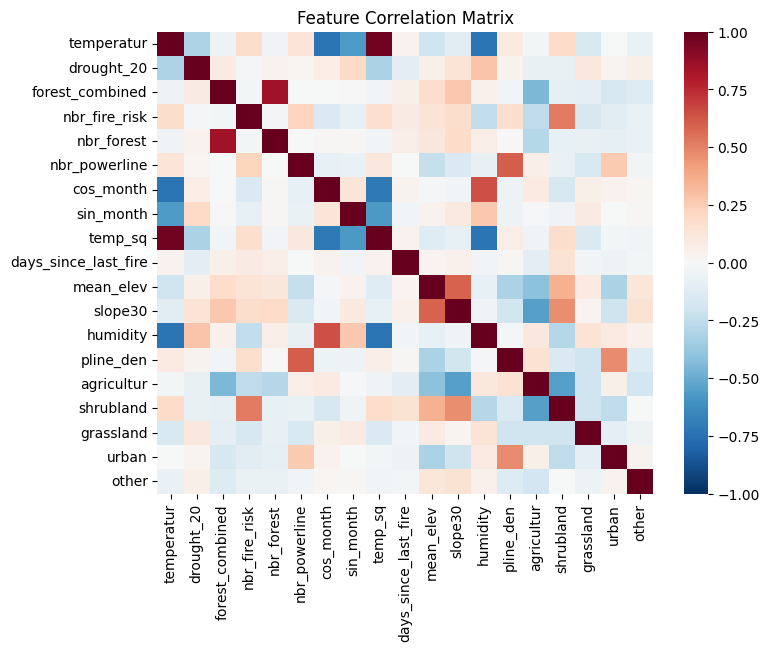

                 feature        VIF
0             temperatur  99.098796
2        forest_combined  45.546659
8                temp_sq  44.078411
4             nbr_forest  28.057416
12              humidity  19.732663
14            agricultur  11.632171
5          nbr_powerline  11.116571
15             shrubland  10.155375
13             pline_den   7.477490
10             mean_elev   4.732387
6              cos_month   3.706472
16             grassland   3.247947
11               slope30   3.192348
17                 urban   2.383303
1             drought_20   2.195072
7              sin_month   2.086108
3          nbr_fire_risk   1.981978
18                 other   1.742689
9   days_since_last_fire   1.179575


In [12]:
# 
use_feats = [
    "temperatur","drought_20",
    "forest_combined","nbr_fire_risk",
    "nbr_forest","nbr_powerline","cos_month","sin_month",
    "temp_sq","days_since_last_fire",
    "mean_elev","slope30","humidity","pline_den",
    "agricultur","shrubland","grassland","urban","other"
]

# 
df = df_train_raw.copy()
# bring in neighbor cols from the scaled df_tr
for nb in ["nbr_forest","nbr_road","nbr_powerline","nbr_fire_risk","neighbor_ERI"]:
    if nb in df_tr.columns:
        df[nb] = df_tr[nb]

# ubset to only the columns you care about and that are numeric
X = df[use_feats].select_dtypes(include=[np.number]).copy()

# Clean out infinities & missing
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())     # or .dropna(axis=0) if you prefer


# Correlation heatmap
import seaborn as sns, matplotlib.pyplot as plt
corr = X.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="RdBu_r", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

# VIF table
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
vif_df = pd.DataFrame({
    "feature": X.columns,
    "VIF": [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
}).sort_values("VIF", ascending=False)
print(vif_df)



AG Ring Buffer IBS: 0.1480 ± 0.0742


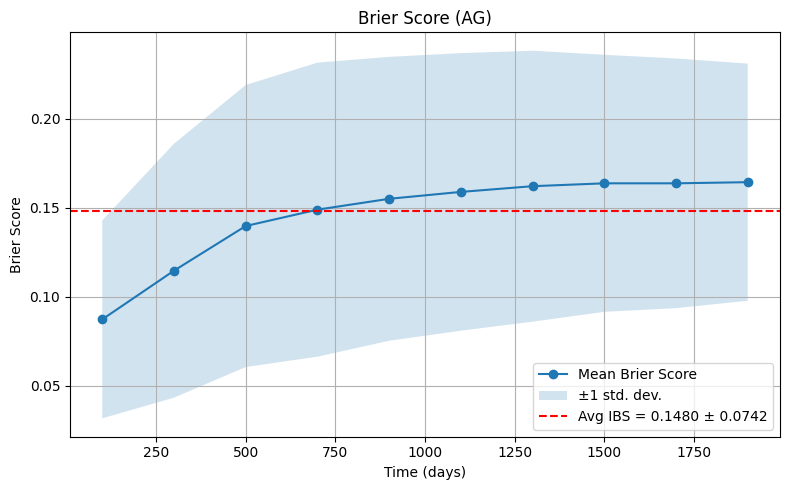

In [13]:
# Stack Brier scores from each fold
brier_matrix = np.stack(all_brier_scores)

# Calculate mean and std
mean_bs = brier_matrix.mean(axis=0)
std_bs = brier_matrix.std(axis=0, ddof=1)

# Integrated Brier Score per fold
ibs_per_fold = [
    np.trapezoid(bs, eval_times) / (eval_times[-1] - eval_times[0])
    for bs in brier_matrix
]
ibs_mean = np.mean(ibs_per_fold)
ibs_std  = np.std(ibs_per_fold, ddof=1)

# Print IBS
print(f"\nAG Ring Buffer IBS: {ibs_mean:.4f} ± {ibs_std:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(eval_times, mean_bs, marker="o", label="Mean Brier Score")
plt.fill_between(eval_times,
                 mean_bs - std_bs,
                 mean_bs + std_bs,
                 alpha=0.2,
                 label="±1 std. dev.")
plt.axhline(ibs_mean, color="red", linestyle="--",
            label=f"Avg IBS = {ibs_mean:.4f} ± {ibs_std:.4f}")
plt.xlabel("Time (days)")
plt.ylabel("Brier Score")
plt.title("Brier Score (AG)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


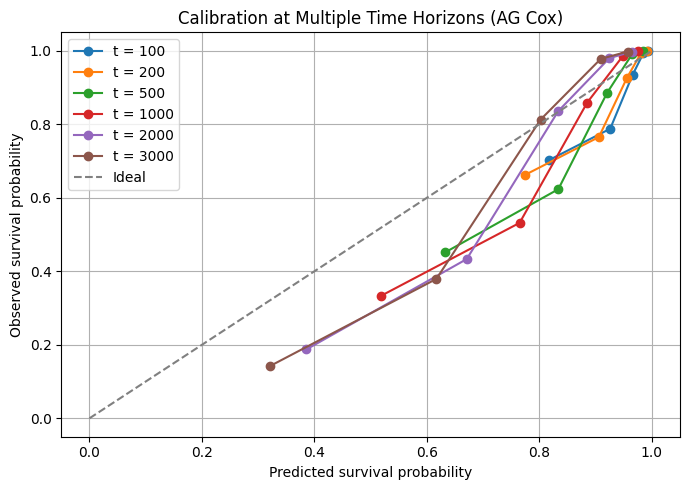

In [15]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd

# 1. Choose time horizons
time_horizons = [100, 200, 500, 1000, 2000, 3000]
n_bins = 5

calibration_data = []

for t in time_horizons:
    # 2. Predict survival probabilities at time t
    surv_df = cph.predict_survival_function(df_te[features], times=[t])
    
    # lifelines returns DataFrame with time as index and rows = individuals
    pred_surv = surv_df.T[t].values  # shape (n_samples,)
    
    # 3. Bin individuals into quantiles based on predicted survival
    df_te["pred_surv_prob"] = pred_surv
    df_te["risk_group"] = pd.qcut(pred_surv, q=n_bins, labels=False)

    group_pred, group_obs = [], []
    kmf = KaplanMeierFitter()

    for group in range(n_bins):
        sub = df_te[df_te["risk_group"] == group]
        if len(sub) < 1:
            continue
        group_pred.append(sub["pred_surv_prob"].mean())
        kmf.fit(durations=sub["duration"], event_observed=sub["fire_occur"])
        group_obs.append(kmf.predict(t))

    for gp, go in zip(group_pred, group_obs):
        calibration_data.append({"time": t, "pred": gp, "obs": go})

# 4. Plot
df_cal = pd.DataFrame(calibration_data)

plt.figure(figsize=(7, 5))
for t in df_cal["time"].unique():
    sub = df_cal[df_cal["time"] == t]
    plt.plot(sub["pred"], sub["obs"], marker="o", label=f"t = {t}")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Ideal")
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival probability")
plt.title("Calibration at Multiple Time Horizons (AG Cox)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd

# 1) Columns to exclude
exclude = {
    "sin_month", "cos_month", "centroid_x", "centroid_y", "north","east", "west",
    "unique_idx", "sample_weight", "prev_stop_time","start_time", "level_0", "id", "raw_start_time", "south", "no_prior_fire", "stop_time"
}

numeric_cols = event_df.select_dtypes(include="number").columns
key_cols = [c for c in numeric_cols if c not in exclude]

# 3) Compute mean and standard deviation
means = event_df[key_cols].mean().round(5)
stds  = event_df[key_cols].std(ddof=1).round(5)

# 4) Build summary DataFrame
summary = pd.DataFrame({
    "Covariate":   key_cols,
    "Mean":        means.values,
    "Std. Dev.":   stds.values
})

# 5) Print it
print(summary.to_string(index=False))


           Covariate       Mean  Std. Dev.
          fire_occur    0.30155    0.45894
          temperatur   17.56067    8.73826
          wind_speed   11.37913    7.62012
          drought_20    0.03100    0.03662
            humidity   57.56357   21.50248
           mean_elev  494.95131  421.46579
             slope30    0.19376    0.23281
            road_den  785.01927  911.88287
           pline_den    0.00028    0.00017
               urban    0.04580    0.09125
              forest    0.29235    0.21646
          agricultur    0.31545    0.27544
           irrigated    0.02136    0.09081
           shrubland    0.19962    0.21108
           grassland    0.09748    0.14102
               other    0.02793    0.08699
            duration 1824.04629 1758.99243
days_since_last_fire  265.54397  714.37721


In [9]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
temperatur,1.713881,5.550460,0.149530,1.420807,2.006954,4.140462,7.440622,0.0,11.461781,2.052504e-30,98.620458
wind_speed,0.702156,2.018099,0.112048,0.482546,0.921766,1.620195,2.513725,0.0,6.266574,3.690788e-10,31.335352
drought_20,-1.735236,0.176359,0.199365,-2.125985,-1.344488,0.119315,0.260673,0.0,-8.703813,3.209145e-18,58.112517
forest_combined,0.568990,1.766482,0.109026,0.355303,0.782677,1.426612,2.187319,0.0,5.218843,1.800440e-07,22.405147
nbr_fire_risk,4.113767,61.176757,0.164992,3.790390,4.437145,44.273646,84.533258,0.0,24.933183,3.250337e-137,453.403560
nbr_forest,0.615356,1.850315,0.153732,0.314046,0.916666,1.368953,2.500939,0.0,4.002772,6.260454e-05,13.963373
nbr_powerline,-0.090497,0.913477,0.250853,-0.582160,0.401166,0.558690,1.493565,0.0,-0.360757,7.182809e-01,0.477380
cos_month,0.006291,1.006311,0.024973,-0.042655,0.055238,0.958242,1.056792,0.0,0.251928,8.010965e-01,0.319952
sin_month,0.254221,1.289457,0.031249,0.192973,0.315468,1.212850,1.370901,0.0,8.135253,4.110788e-16,51.111435


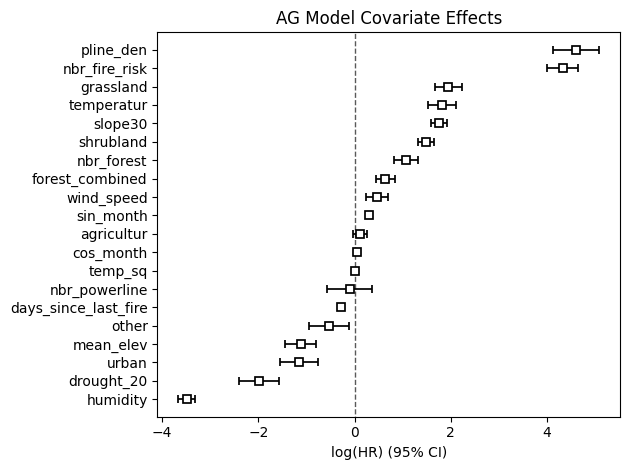

In [16]:
cph.plot()
plt.title("AG Model Covariate Effects")
plt.tight_layout()
plt.show()

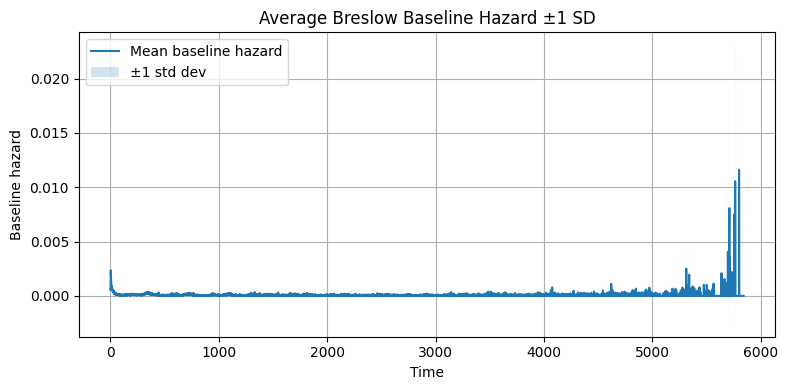

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Collect & align baseline hazards ---
# Each model.baseline_hazard_ is a DataFrame indexed by time, column "baseline hazard"
bh_list = []
for fold, mdl in enumerate(ensemble_models):
    bh = mdl["model"].baseline_hazard_.copy()
    bh.columns = [f"hazard_{fold}"]
    bh_list.append(bh)

# merge them on the timeline (outer join), then compute mean & std
bh_all = pd.concat(bh_list, axis=1).sort_index()
mean_h = bh_all.mean(axis=1)
std_h  = bh_all.std(axis=1, ddof=1)


# --- 2) Plot averaged baseline hazard ---
plt.figure(figsize=(8,4))
plt.step(mean_h.index, mean_h.values, where="post", label="Mean baseline hazard")
plt.fill_between(mean_h.index,
                 mean_h - std_h,
                 mean_h + std_h,
                 step="post",
                 alpha=0.2,
                 label="±1 std dev")
plt.xlabel("Time")
plt.ylabel("Baseline hazard")
plt.title("Average Breslow Baseline Hazard ±1 SD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [35]:
import psutil

mem = psutil.virtual_memory()
print(f"System: {mem.used/1e9:.1f} GB used / {mem.total/1e9:.1f} GB total")

p = psutil.Process()  # your own Python process
print(f"Process: {p.memory_info().rss/1e9:.2f} GB resident")


System: 10.3 GB used / 16.5 GB total
Process: 0.29 GB resident


In [26]:
# 1) sort & reset index
ed = event_df.sort_values(["id", "start_time"]).reset_index(drop=True)

# 2) build masks
is_bad     = ed["start_time"] >= ed["stop_time"]
prev_fire  = ed["fire_occur"].shift(1) == 1
same_grid  = ed["id"].shift(1) == ed["id"]

# 3) count how many bad intervals follow a fire in the same grid
bad_after_fire = (is_bad & prev_fire & same_grid).sum()

print(f"{bad_after_fire} intervals immediately follow a fire")


0 intervals immediately follow a fire


In [100]:
# Find all intervals where start_time ≥ stop_time
bad = event_df.loc[event_df["start_time"] == event_df["stop_time"]-1,
                   ["id","start_time","stop_time","fire_occur"]]
print(f"{len(bad)} bad intervals:\n", bad)


806 bad intervals:
              id  start_time  stop_time  fire_occur
349     38394.0        5694       5695           1
382     38403.0        5842       5843           0
877     39270.0        5696       5697           1
1039    39490.0        5345       5346           1
1207    39709.0        3567       3568           1
...         ...         ...        ...         ...
73493  104621.0        5420       5421           1
73498  104621.0        5793       5794           1
73598  104841.0        4692       4693           1
73599  104841.0        4694       4695           1
73601  104841.0        4703       4704           1

[806 rows x 4 columns]


In [ ]:

cph.print_summary()


model,lifelines.CoxPHFitter
duration col,'duration'
event col,'fire_occur'
cluster col,'id'
penalizer,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0..."
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,44685
number of events observed,14778
partial log-likelihood,-138222.81


In [56]:
# assuming your main df is called `df_model` or `gdf`
# and it has columns `no_prior_fire` (0/1) and `fire_occur` (0/1)
summary = (
    df_model
      .groupby("no_prior_fire")["fire_occur"]
      .agg(total_intervals="count", total_fires="sum")
      .reset_index()
)
summary["fire_rate"] = summary["total_fires"] / summary["total_intervals"]
print(summary)


   no_prior_fire  total_intervals  total_fires  fire_rate
0              0            22932        12124   0.528694
1              1            32873         4704   0.143096


In [17]:
import numpy as np
import pandas as pd

def compute_seasonality_cos_sin(t_days):
    cos_month = np.cos(2 * np.pi * (t_days % 365) / 365)
    sin_month = np.sin(2 * np.pi * (t_days % 365) / 365)
    return cos_month, sin_month


def day_to_month(day):
    # Approximate conversion: assume 30-day months
    return min(12, int(day // 30) + 1)


def get_monthly_values(df_monthly, grid_id, month, stat='median'):
    """
    Retrieve monthly values for your model features:
      - temperatur    ← from temperature_{stat}
      - wind_speed    ← from wind_speed_{stat}
      - drought_20    ← from drought20_{stat}
      - humidity      ← from humidity_{stat}
    """
    suffix = f"_{stat}"
    # Subset to the one row
    row = df_monthly[(df_monthly["id"] == grid_id) & (df_monthly["month"] == month)]
    if row.empty:
        raise ValueError(f"No monthly data for grid_id={grid_id}, month={month}")
    row = row.iloc[0]  # turn into a Series
    
    # pull out each, with a fallback if naming is slightly different
    temp_col = f"temperature{suffix}"
    wind_col = f"wind_speed{suffix}"
    drought_col = f"drought20{suffix}"
    humid_col = f"humidity{suffix}"
    
    return {
        "temperatur":   row[temp_col],
        "wind_speed":   row[wind_col],
        "drought_20":   row[drought_col],
        "humidity":     row[humid_col],
    }



def build_baseline_row(event_df, grid_id):
    """
    Build a one‐row “baseline” using median values, and ensure
    static covariates are present by pulling the first non‐null when needed.
    Also computes centroid_x/centroid_y if not already present.
    """
    subset = event_df[event_df["id"] == grid_id].copy()
    if subset.empty:
        raise ValueError(f"No data for grid_id={grid_id}")

    # ensure the x/y columns exist
    if "centroid_x" not in subset.columns or "centroid_y" not in subset.columns:
        subset["centroid_x"] = subset["centroid"].x
        subset["centroid_y"] = subset["centroid"].y

    # numeric medians
    baseline = subset.median(numeric_only=True).to_dict()

    required_features = [
        "pline_den", "grassland", "shrubland", "agricultur", "forest", "road_den",
        "slope30", "mean_elev", "no_prior_fire", "centroid_x", "centroid_y",
        "urban", "other"
    ]
    for var in required_features:
        if var not in baseline or pd.isna(baseline[var]):
            non_null = subset[var].dropna()
            baseline[var] = non_null.iloc[0] if len(non_null) else 0.0

    return baseline



def compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius):
    """
    Compute your nbr_* features exactly as in training:
      nbr_fire_risk, nbr_forest, nbr_road, nbr_powerline
    """
    point = np.array([row["centroid_x"], row["centroid_y"]])
    neighbors = tree_train.query_ball_point(point, neighbor_radius)

    # if no neighbors, fall back to the training‐set median
    if not neighbors:
        for col in ["nbr_fire_risk", "nbr_forest", "nbr_road", "nbr_powerline"]:
            row[col] = df_train[col].median()
        return row

    neighs = df_train.iloc[neighbors]
    dists  = np.linalg.norm(coords_train[neighbors] - point, axis=1) + 1e-6
    weights = 1.0 / dists

    row.update({
        "nbr_fire_risk":    neighs["fire_occur"].sum() / (neighs["duration"].sum() + 1e-9),
        "nbr_forest":       np.average(neighs["forest"], weights=weights),
        "nbr_road":         np.average(neighs["road_den"], weights=weights),
        "nbr_powerline":    np.average(neighs["pline_den"], weights=weights),
    })
    return row


Survival range: 0.7440664898675906 → 0.9997490115427116
Hazard   range: 0.0002510199601626317 → 0.2956248800405358


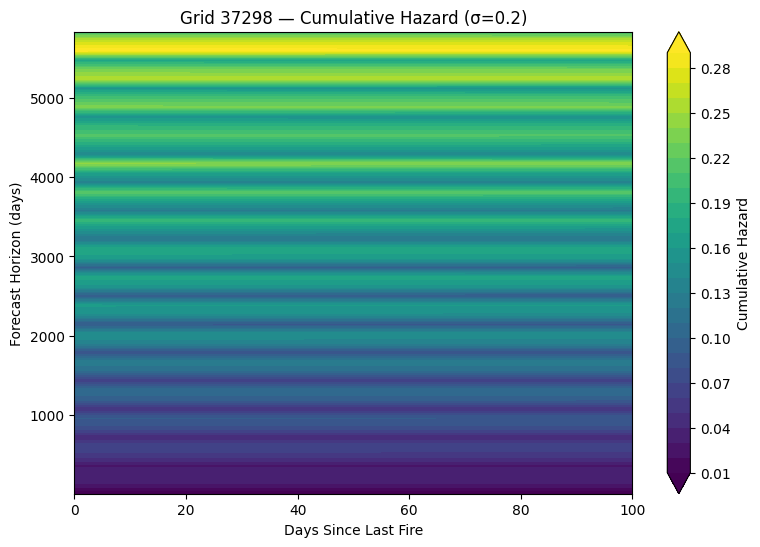

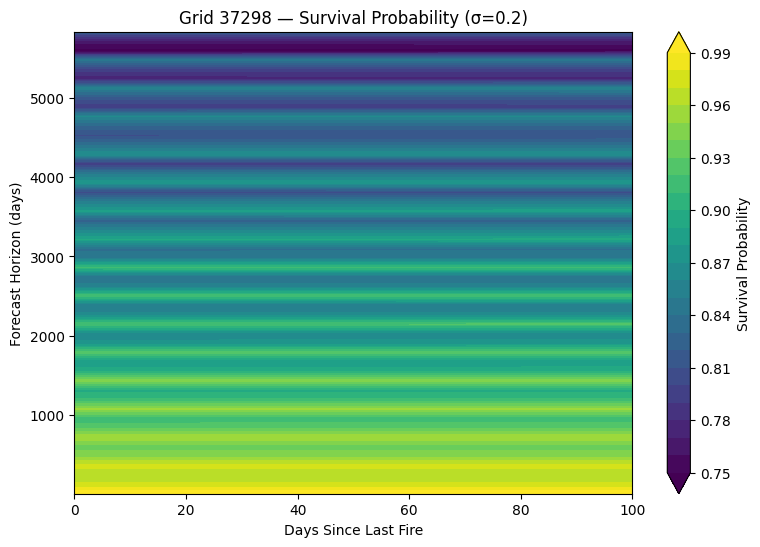

In [52]:
# mediterranian plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def predict_and_plot_with_AG_ensemble(
    ensemble_models,
    event_df,
    df_monthly,
    grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.2
):
    # 1) Ranges
    days_since_fire_range = np.arange(0, 101, 5)

    # Build forecast_range as union of all baseline survival times
    all_times = np.unique(np.concatenate([
        em["model"].baseline_survival_.index.values 
        for em in ensemble_models
    ]))
    forecast_range = np.linspace(all_times.min(), all_times.max(), 50)

    # 2) Prepare storage
    n_f = len(forecast_range)
    n_d = len(days_since_fire_range)
    survival_matrix = np.zeros((n_f, n_d))
    hazard_matrix   = np.zeros((n_f, n_d))

    # 3) Model features
    predictor_vars = [
        "temperatur","wind_speed","drought_20",
        "forest_combined","nbr_fire_risk",
        "nbr_forest","nbr_powerline","cos_month","sin_month",
        "no_prior_fire","temp_sq","days_since_last_fire",
        "mean_elev","slope30","humidity","pline_den",
        "agricultur","shrubland","grassland","urban","other"
    ]
    cols_to_scale = [
        "temperatur","wind_speed","drought_20","forest_combined",
        "days_since_last_fire","nbr_fire_risk","nbr_powerline","nbr_forest",
        "humidity","mean_elev","slope30",
        "agricultur","shrubland","grassland","urban","other","pline_den"
    ]

    # 4) Loop through grid of (forecast_time, days_since_fire)
    for i, t in enumerate(forecast_range):
        month = day_to_month(t % 365)
        monthly = get_monthly_values(df_monthly, grid_id, month, stat=statistic)

        for j, dsf in enumerate(days_since_fire_range):
            # Baseline row
            row = build_baseline_row(event_df, grid_id)
            row["days_since_last_fire"] = dsf
            c, s = compute_seasonality_cos_sin(t)
            row["cos_month"], row["sin_month"] = c, s
            row.update(monthly)

            # Ensure required static fields
            for var in ["pline_den","grassland","shrubland","agricultur",
                        "slope30","mean_elev","no_prior_fire","urban","other"]:
                row[var] = row.get(var, 0.0)

            # Predict for each fold
            survs = []
            for mdl in ensemble_models:
                rm = compute_neighbor_features(
                    row.copy(),
                    mdl["df_train_raw"],
                    mdl["coords_train"],
                    mdl["tree_train"],
                    neighbor_radius
                )
                rm["forest_combined"] = (rm["forest"] + rm["nbr_forest"]) / 2
                rm["road_combined"]   = (rm["road_den"] + rm["nbr_road"]) / 2

                X = pd.DataFrame([rm])
                Xs = X.copy()
                Xs[cols_to_scale] = mdl["scaler"].transform(X[cols_to_scale])
                Xs["temp_sq"] = Xs["temperatur"] ** 2

                Xf = Xs[predictor_vars]
                sf = mdl["model"].predict_survival_function(Xf, times=[t])
                survs.append(sf.iloc[0, 0])

            avg = np.mean(survs)
            survival_matrix[i, j] = avg
            hazard_matrix[i, j]   = -np.log(avg) if avg > 0 else np.nan

    # 5) Debug ranges
    print("Survival range:", np.nanmin(survival_matrix), "→", np.nanmax(survival_matrix))
    print("Hazard   range:", np.nanmin(hazard_matrix),   "→", np.nanmax(hazard_matrix))

    # 6) Smooth
    surv_sm = gaussian_filter(survival_matrix, sigma=sigma)
    haz_sm  = gaussian_filter(hazard_matrix,   sigma=sigma)

    # 7) Plot
    Xg, Yg = np.meshgrid(days_since_fire_range, forecast_range)

    plt.figure(figsize=(9,6))
    cf = plt.contourf(Xg, Yg, haz_sm, levels=30, extend="both")
    plt.colorbar(cf, label="Cumulative Hazard")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Grid {grid_id} — Cumulative Hazard (σ={sigma})")
    plt.xlim(0, 100)
    plt.ylim(forecast_range.min(), forecast_range.max())
    plt.show()

    plt.figure(figsize=(9,6))
    cf2 = plt.contourf(Xg, Yg, surv_sm, levels=30, extend="both")
    plt.colorbar(cf2, label="Survival Probability")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Grid {grid_id} — Survival Probability (σ={sigma})")
    plt.xlim(0, 100)
    plt.ylim(forecast_range.min(), forecast_range.max())
    plt.show()


# Example usage:
grid_id = int(37298.0)
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y
gdf["centroid"]    = gdf.geometry.centroid

event_df = gdf.copy()

predict_and_plot_with_AG_ensemble(
    ensemble_models=ensemble_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.2
)



In [9]:
import gc
del burn_areas
gc.collect()

14

In [59]:
import gc
del gdf, df_model, ensemble_models
gc.collect()

12235

In [60]:
import psutil

mem = psutil.virtual_memory()
print(f"System: {mem.used/1e9:.1f} GB used / {mem.total/1e9:.1f} GB total")

p = psutil.Process()  # your own Python process
print(f"Process: {p.memory_info().rss/1e9:.2f} GB resident")


System: 11.4 GB used / 16.5 GB total
Process: 0.46 GB resident


In [161]:
grid_fire_counts = (
    event_df
    .groupby("id")["fire_occur"]
    .sum()
    .reset_index(name="fire_count")
)

# 2) Sort descending to see which grids have the most fires
top_grids = grid_fire_counts.sort_values("fire_count", ascending=False)
top_grids

,id,fire_count
705,41017.0,114
775,41237.0,94
14356,81114.0,86
769,41231.0,83
696,41008.0,80
...,...,...
3988,50051.0,0
25,37740.0,0
26,37741.0,0
3989,50052.0,0


## RSF model

In [10]:
# rsf uden ring nbr
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import brier_score
from sksurv.util import Surv



gdf = event_df.copy()

# Make sure gdf is a GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# Now compute centroids
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y
gdf["centroid"] = gdf.geometry.centroid

# ─── 1) BASIC FEATURES ───────────────────────────────────────────────────────
# split centroid into x/y
# half a day (you can tweak)
eps = 0.5  
mask_zero = (gdf["fire_occur"] == 1) & (gdf["stop_time"] == gdf["start_time"])
gdf.loc[mask_zero, "stop_time"] += eps


# duration of each interval
gdf["duration"] = gdf["stop_time"] - gdf["start_time"]
# Ensure centroids & duration
gdf["centroid"] = gdf.geometry.centroid



# Spatial blocking
n_x, n_y = 5, 5
gdf["x_block"] = pd.cut(gdf["centroid_x"], bins=n_x, labels=False)
gdf["y_block"] = pd.cut(gdf["centroid_y"], bins=n_y, labels=False)
gdf["spatial_block"] = gdf["x_block"].astype(str) + "_" + gdf["y_block"].astype(str)

# Select variables
model_vars = [
    "fire_occur", "id", "start_time", "stop_time", "duration",
    "temperatur", "drought_20", "forest", "road_den", "pline_den",
    "grassland", "shrubland", "agricultur", "days_since_last_fire",
    "mean_elev", "no_prior_fire", "cos_month", "sin_month",
    "slope30", "humidity", "urban", "other", "centroid_x", "centroid_y"
]
df_model = gdf[model_vars + ["spatial_block"]].select_dtypes(include=[np.number]).copy()
df_model["spatial_block"] = gdf["spatial_block"]

# Prepare
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)
ensemble_rsf_models = []
train_cidx, test_cidx = [], []
eval_times = np.arange(100, 2000, 200)
all_brier_scores = []
ibs_per_fold = []

for fold, (tr_idx, te_idx) in enumerate(gkf.split(df_model, groups=df_model["spatial_block"])):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    df_tr = df_model.iloc[tr_idx].drop(columns="spatial_block").copy()
    df_te = df_model.iloc[te_idx].drop(columns="spatial_block").copy()

    # Neighbor features
    coords_tr = df_tr[["centroid_x", "centroid_y"]].values
    coords_te = df_te[["centroid_x", "centroid_y"]].values
    tree = cKDTree(coords_tr)
    R = 10000
    lag_days = 10
    nbr_cols = ["nbr_fire_risk", "nbr_forest", "nbr_road", "nbr_powerline"]

    for D in [df_tr, df_te]:
        for c in nbr_cols:
            D[c] = np.nan

    for i, pt in enumerate(coords_tr):
        stop_t = df_tr.iloc[i]["stop_time"]
        nbrs = tree.query_ball_point(pt, R)
        valid_nbrs = [j for j in nbrs if j != i and df_tr.iloc[j]["stop_time"] < (stop_t - lag_days)]

        if valid_nbrs:
            dists = np.linalg.norm(coords_tr[valid_nbrs] - pt, axis=1) + 1e-6
            w = 1.0 / dists
            sub = df_tr.iloc[valid_nbrs]
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_fire_risk")] = sub["fire_occur"].sum() / sub["duration"].sum()
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_forest")] = np.average(sub["forest"], weights=w)
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_road")] = np.average(sub["road_den"], weights=w)
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_powerline")] = np.average(sub["pline_den"], weights=w)

    for i, pt in enumerate(coords_te):
        stop_t = df_te.iloc[i]["stop_time"]
        nbrs = tree.query_ball_point(pt, R)
        valid_nbrs = [j for j in nbrs if df_tr.iloc[j]["stop_time"] < (stop_t - lag_days)]

        if valid_nbrs:
            dists = np.linalg.norm(coords_tr[valid_nbrs] - pt, axis=1) + 1e-6
            w = 1.0 / dists
            sub = df_tr.iloc[valid_nbrs]
            df_te.iloc[i, df_te.columns.get_loc("nbr_fire_risk")] = sub["fire_occur"].sum() / sub["duration"].sum()
            df_te.iloc[i, df_te.columns.get_loc("nbr_forest")] = np.average(sub["forest"], weights=w)
            df_te.iloc[i, df_te.columns.get_loc("nbr_road")] = np.average(sub["road_den"], weights=w)
            df_te.iloc[i, df_te.columns.get_loc("nbr_powerline")] = np.average(sub["pline_den"], weights=w)

    neighbor_features = ["nbr_forest","nbr_road","nbr_powerline"]
    for df in [df_tr, df_te]:
        df[neighbor_features] = df[neighbor_features].fillna(df_tr[neighbor_features].median())
        df["nbr_fire_risk"] = df["nbr_fire_risk"].fillna(0.0)


    for D in [df_tr, df_te]:
        D["forest_combined"] = (D["forest"] + D["nbr_forest"]) / 2
        D["temp_sq"] = D["temperatur"] ** 2

    scale_cols = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other"
    ]
    df_train_raw = df_tr.copy()
    scaler = MinMaxScaler()
    df_tr[scale_cols] = scaler.fit_transform(df_tr[scale_cols])
    df_te[scale_cols] = scaler.transform(df_te[scale_cols])

    df_tr["fire_occur"] = df_tr["fire_occur"].astype(bool)
    df_te["fire_occur"] = df_te["fire_occur"].astype(bool)

    # Final feature set
    rsf_features = [
        "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
        "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "cos_month", "temp_sq", "mean_elev", 
        "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month"
    ]

    y_train = Surv.from_arrays(event=df_tr["fire_occur"], time=df_tr["duration"])
    y_test = Surv.from_arrays(event=df_te["fire_occur"], time=df_te["duration"])
    X_train = df_tr[rsf_features]
    X_test = df_te[rsf_features]

    w = np.ones(len(df_tr))

    # Halve the weight for any “first‐ever” interval
    # w[df_tr["no_prior_fire"] == 1] *= 0.3

    # And also halve the weight for any 1‑day‑since‑last‑fire interval
    w[df_tr["days_since_last_fire"] == 1] *= 0.4

    rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=30, min_samples_leaf=40,
                               max_features=0.1, n_jobs=1, random_state=42)
    rsf.fit(X_train, y_train, sample_weight=w)

    train_pred = rsf.predict(X_train)
    test_pred = rsf.predict(X_test)

    c_idx_train = concordance_index_censored(y_train["event"], y_train["time"], train_pred)[0]
    c_idx_test = concordance_index_censored(y_test["event"], y_test["time"], test_pred)[0]
    surv_funcs = rsf.predict_survival_function(X_test, return_array=False)

    # Convert survival functions into array format (samples x times)
    surv_array = np.asarray([[fn(t) for t in eval_times] for fn in surv_funcs])

    # Compute Brier scores for each time point
    _, bs_curve = brier_score(y_train, y_test, surv_array, eval_times)

    # Store Brier score curve and IBS
    all_brier_scores.append(bs_curve.copy())
    ibs = np.trapezoid(bs_curve, eval_times) / (eval_times.max() - eval_times.min())
    ibs_per_fold.append(ibs)

    print(f"Train C-index: {c_idx_train:.4f}")
    print(f"Test  C-index: {c_idx_test:.4f}")

    ensemble_rsf_models.append({
    "model": rsf,
    "scaler": scaler,
    "df_train_raw": df_train_raw,
    "df_train": df_tr,
    "coords_train": coords_tr,
    "tree_train": tree
    })

    train_cidx.append(c_idx_train)
    test_cidx.append(c_idx_test)

print(f"\nAvg Train C-index: {np.mean(train_cidx):.4f}")
print(f"Avg Test  C-index: {np.mean(test_cidx):.4f}")



--- Fold 1/5 ---
Train C-index: 0.9225
Test  C-index: 0.7316

--- Fold 2/5 ---
Train C-index: 0.8939
Test  C-index: 0.9195

--- Fold 3/5 ---
Train C-index: 0.8966
Test  C-index: 0.8928

--- Fold 4/5 ---
Train C-index: 0.9097
Test  C-index: 0.8770

--- Fold 5/5 ---
Train C-index: 0.9044
Test  C-index: 0.8964

Avg Train C-index: 0.9054
Avg Test  C-index: 0.8635



RSF Integrated Brier Score (IBS): 0.1154 ± 0.0610


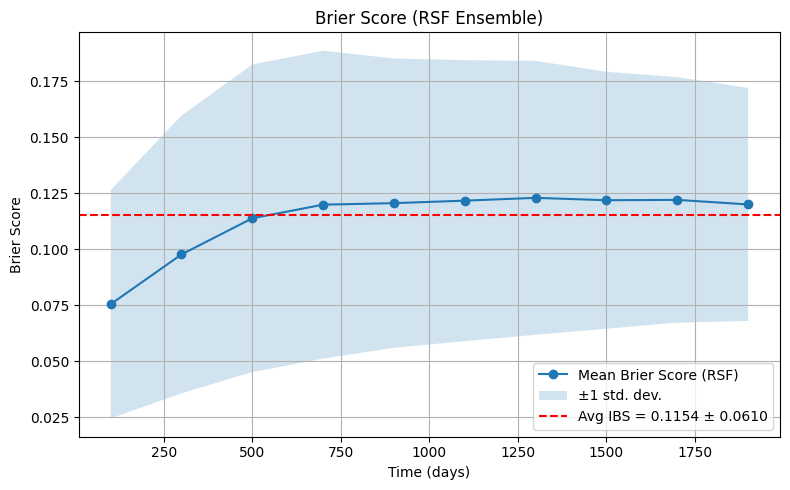

In [12]:
# Final Brier score aggregation
brier_matrix_rsf = np.stack(all_brier_scores)
mean_bs_rsf = brier_matrix_rsf.mean(axis=0)
std_bs_rsf = brier_matrix_rsf.std(axis=0, ddof=1)

# Integrated Brier Score (IBS)
ibs_per_fold_rsf = [
    np.trapezoid(bs, eval_times) / (eval_times[-1] - eval_times[0])
    for bs in brier_matrix_rsf
]
ibs_mean_rsf = np.mean(ibs_per_fold_rsf)
ibs_std_rsf = np.std(ibs_per_fold_rsf, ddof=1)

print(f"\nRSF Integrated Brier Score (IBS): {ibs_mean_rsf:.4f} ± {ibs_std_rsf:.4f}")
plt.figure(figsize=(8, 5))
plt.plot(eval_times, mean_bs_rsf, marker="o", label="Mean Brier Score (RSF)")
plt.fill_between(eval_times,
                 mean_bs_rsf - std_bs_rsf,
                 mean_bs_rsf + std_bs_rsf,
                 alpha=0.2,
                 label="±1 std. dev.")
plt.axhline(ibs_mean_rsf, color="red", linestyle="--",
            label=f"Avg IBS = {ibs_mean_rsf:.4f} ± {ibs_std_rsf:.4f}")
plt.xlabel("Time (days)")
plt.ylabel("Brier Score")
plt.title("Brier Score (RSF Ensemble)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


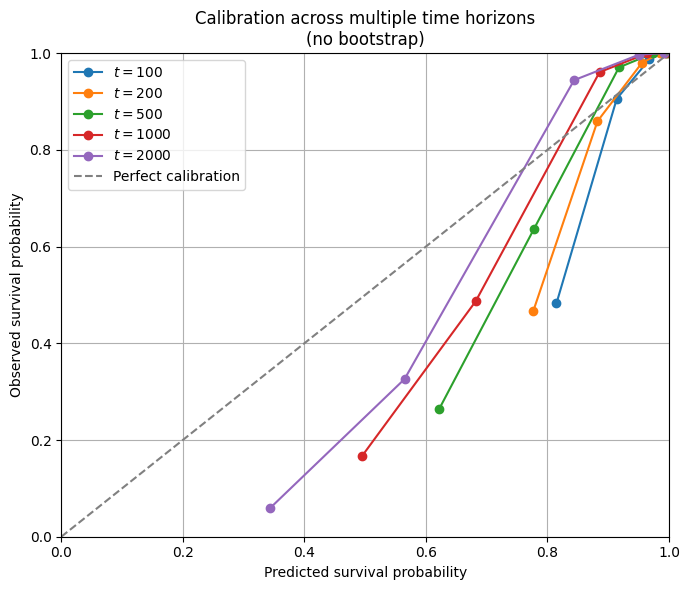

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
import pandas as pd

# Choose horizons and number of bins
time_horizons = [100, 200, 500, 1000, 2000]
n_bins = 5

# Predict full survival curves
surv_funcs = rsf.predict_survival_function(X_test, return_array=False)
df_te["pred_surv_curve"] = surv_funcs

# Init plot
plt.figure(figsize=(7, 6))

for t_hor in time_horizons:
    df_te["pred_surv"] = [fn(t_hor) for fn in df_te["pred_surv_curve"]]
    df_te["risk_bin"] = pd.qcut(df_te["pred_surv"], q=n_bins, labels=False)

    pred_vals, obs_vals = [], []

    for b in range(n_bins):
        bin_group = df_te[df_te["risk_bin"] == b]
        if len(bin_group) < 10:
            continue

        # 1) mean predicted
        pred_vals.append(bin_group["pred_surv"].mean())

        # 2) KM estimate at t_hor
        durations = bin_group["duration"].values
        events = bin_group["fire_occur"].values.astype(bool)

        km_time, km_surv_prob = kaplan_meier_estimator(events, durations)
        obs_prob = np.interp(t_hor, km_time, km_surv_prob)

        obs_vals.append(obs_prob)

    # 3) plot (no error bars)
    plt.plot(pred_vals, obs_vals, "o-", label=f"$t={t_hor}$")

# Reference line
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect calibration")

# Labels & legend
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival probability")
plt.title("Calibration across multiple time horizons\n(no bootstrap)")
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [8]:
# nye model med ring split ift naboer
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored


gdf = event_df.copy()

# Make sure gdf is a GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# Now compute centroids
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y
gdf["centroid"] = gdf.geometry.centroid

# ─── 1) BASIC FEATURES ───────────────────────────────────────────────────────
# split centroid into x/y
# half a day (you can tweak)
eps = 0.5  
mask_zero = (gdf["fire_occur"] == 1) & (gdf["stop_time"] == gdf["start_time"])
gdf.loc[mask_zero, "stop_time"] += eps


# duration of each interval
gdf["duration"] = gdf["stop_time"] - gdf["start_time"]
# Ensure centroids & duration
gdf["centroid"] = gdf.geometry.centroid



# Spatial blocking
n_x, n_y = 5, 5
gdf["x_block"] = pd.cut(gdf["centroid_x"], bins=n_x, labels=False)
gdf["y_block"] = pd.cut(gdf["centroid_y"], bins=n_y, labels=False)
gdf["spatial_block"] = gdf["x_block"].astype(str) + "_" + gdf["y_block"].astype(str)

# Select variables
model_vars = [
    "fire_occur", "id", "start_time", "stop_time", "duration",
    "temperatur", "drought_20", "forest", "road_den", "pline_den",
    "grassland", "shrubland", "agricultur", "days_since_last_fire",
    "mean_elev", "no_prior_fire", "cos_month", "sin_month",
    "slope30", "humidity", "urban", "other", "centroid_x", "centroid_y"
]
df_model = gdf[model_vars + ["spatial_block"]].select_dtypes(include=[np.number]).copy()
df_model["spatial_block"] = gdf["spatial_block"]

# Prepare
n_splits = 6
gkf = GroupKFold(n_splits=n_splits)
ensemble_rsf_models = []
train_cidx, test_cidx = [], []

for fold, (tr_idx, te_idx) in enumerate(gkf.split(df_model, groups=df_model["spatial_block"])):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    df_tr = df_model.iloc[tr_idx].drop(columns="spatial_block").copy()
    df_te = df_model.iloc[te_idx].drop(columns="spatial_block").copy()

    # Neighbor features
    coords_tr = df_tr[["centroid_x", "centroid_y"]].values
    coords_te = df_te[["centroid_x", "centroid_y"]].values
    tree = cKDTree(coords_tr)
    R = 11000
    R_outer = 20000
    lag_days = 10
    nbr_cols = ["nbr_fire_risk", "nbr_forest", "nbr_road", "nbr_powerline"]

    for D in [df_tr, df_te]:
        for c in nbr_cols:
            D[c] = np.nan

    for i, pt in enumerate(coords_tr):
        my_stop = df_tr.iloc[i]["start_time"]

        all_nb = tree.query_ball_point(pt, R)

        past_nb = [
            j for j in all_nb
            if j != i
            and df_tr.iloc[j]["stop_time"] < (my_stop - lag_days)
        ]

        if past_nb:
            dists = np.linalg.norm(coords_tr[past_nb] - pt, axis=1) + 1e-6
            w = 1.0 / dists
            sub = df_tr.iloc[past_nb]

            df_tr.iloc[i, df_tr.columns.get_loc("nbr_fire_risk")] = (
                sub["fire_occur"].sum() / sub["duration"].sum()
            )
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_forest")] = np.average(sub["forest"], weights=w)
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_road")] = np.average(sub["road_den"], weights=w)
            df_tr.iloc[i, df_tr.columns.get_loc("nbr_powerline")] = np.average(sub["pline_den"], weights=w)



    # TEST neighbors (only from TRAIN history)
    coords_te = df_te[["centroid_x","centroid_y"]].values
    # ─── TEST neighbors ────────────────────────────────────
    for i, pt in enumerate(coords_te):
        my_start = df_te.iloc[i]["start_time"]

        # 1) find all training pts within R_outer
        all_nb = tree.query_ball_point(pt, R_outer)

        # 2) filter by temporal lag and by distance >= R
        past_nb = []
        for j in all_nb:
            stop_j = df_tr.iloc[j]["stop_time"]
            if stop_j < (my_start - lag_days):
                dist = np.linalg.norm(coords_tr[j] - pt)
                if R <= dist <= R_outer:
                    past_nb.append((j, dist))

        if not past_nb:
            # falls back to nbr_fire_risk=0 and median statics
            continue

        # 3) compute weights and stats only on this annulus set
        idxs, dists = zip(*past_nb)
        w = 1.0 / (np.array(dists) + 1e-6)
        sub = df_tr.iloc[list(idxs)]

        df_te.at[df_te.index[i], "nbr_fire_risk"] = sub["fire_occur"].sum() / sub["duration"].sum()
        df_te.at[df_te.index[i], "nbr_forest"]    = np.average(sub["forest"], weights=w)
        df_te.at[df_te.index[i], "nbr_road"]      = np.average(sub["road_den"], weights=w)
        df_te.at[df_te.index[i], "nbr_powerline"] = np.average(sub["pline_den"], weights=w)

    neighbor_features = ["nbr_forest","nbr_road","nbr_powerline"]
    for df in [df_tr, df_te]:
        df[neighbor_features] = df[neighbor_features].fillna(df_tr[neighbor_features].median())
        df["nbr_fire_risk"] = df["nbr_fire_risk"].fillna(0.0)


    for D in [df_tr, df_te]:
        D["forest_combined"] = (D["forest"] + D["nbr_forest"]) / 2
        D["temp_sq"] = D["temperatur"] ** 2

    scale_cols = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other"
    ]
    df_train_raw = df_tr.copy()
    scaler = MinMaxScaler()
    df_tr[scale_cols] = scaler.fit_transform(df_tr[scale_cols])
    df_te[scale_cols] = scaler.transform(df_te[scale_cols])

    df_tr["fire_occur"] = df_tr["fire_occur"].astype(bool)
    df_te["fire_occur"] = df_te["fire_occur"].astype(bool)

    # Final feature set
    rsf_features = [
        "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
        "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "cos_month", "temp_sq", "mean_elev", 
        "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month"
    ]

    y_train = Surv.from_arrays(event=df_tr["fire_occur"], time=df_tr["duration"])
    y_test = Surv.from_arrays(event=df_te["fire_occur"], time=df_te["duration"])
    X_train = df_tr[rsf_features]
    X_test = df_te[rsf_features]

    w = np.ones(len(df_tr))

    # Halve the weight for any “first‐ever” interval
    # w[df_tr["no_prior_fire"] == 1] *= 0.3

    # And also halve the weight for any 1‑day‑since‑last‑fire interval
    w[df_tr["days_since_last_fire"] == 1] *= 0.4

    rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=30, min_samples_leaf=40,
                               max_features=0.1, n_jobs=1, random_state=42)
    rsf.fit(X_train, y_train, sample_weight=w)

    train_pred = rsf.predict(X_train)
    test_pred = rsf.predict(X_test)

    c_idx_train = concordance_index_censored(y_train["event"], y_train["time"], train_pred)[0]
    c_idx_test = concordance_index_censored(y_test["event"], y_test["time"], test_pred)[0]

    print(f"Train C-index: {c_idx_train:.4f}")
    print(f"Test  C-index: {c_idx_test:.4f}")

    ensemble_rsf_models.append({
    "model": rsf,
    "scaler": scaler,
    "df_train_raw": df_train_raw,
    "df_train": df_tr,
    "coords_train": coords_tr,
    "tree_train": tree
    })

    train_cidx.append(c_idx_train)
    test_cidx.append(c_idx_test)

print(f"\nAvg Train C-index: {np.mean(train_cidx):.4f}")
print(f"Avg Test  C-index: {np.mean(test_cidx):.4f}")



--- Fold 1/6 ---
Train C-index: 0.9322
Test  C-index: 0.7219

--- Fold 2/6 ---
Train C-index: 0.9084
Test  C-index: 0.9064

--- Fold 3/6 ---
Train C-index: 0.9139
Test  C-index: 0.8494

--- Fold 4/6 ---
Train C-index: 0.9144
Test  C-index: 0.8948

--- Fold 5/6 ---
Train C-index: 0.8976
Test  C-index: 0.9609

--- Fold 6/6 ---
Train C-index: 0.9206
Test  C-index: 0.8598

Avg Train C-index: 0.9145
Avg Test  C-index: 0.8655


In [ ]:
event_df

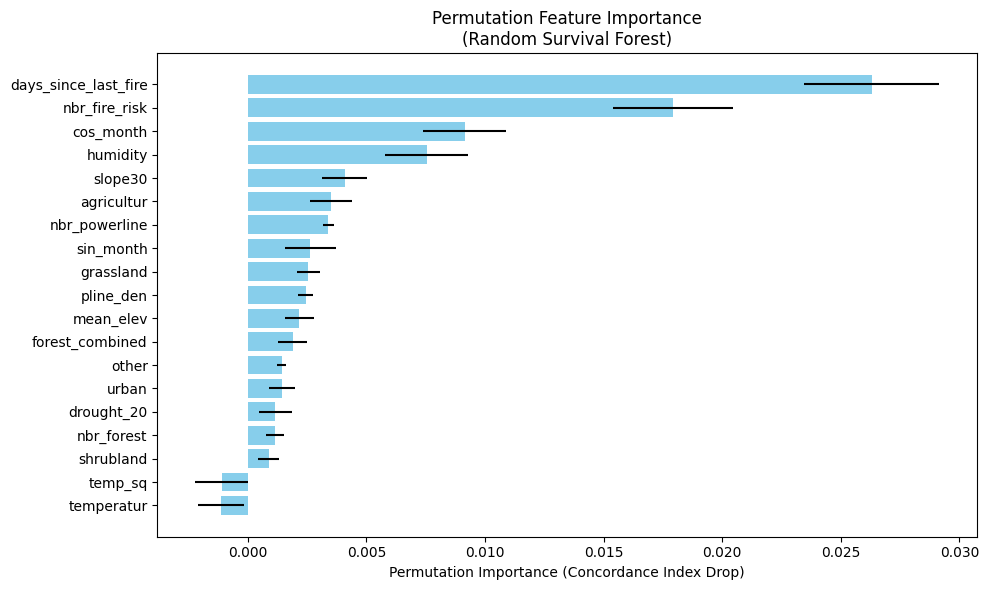

In [16]:
# nye feature
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
import numpy as np

from sksurv.metrics import concordance_index_censored

def concordance_scorer(model, X, y):
    surv_preds = model.predict(X)
    ci = concordance_index_censored(
        event_indicator=y["event"], 
        event_time=y["time"], 
        estimate=surv_preds
    )[0]  # Only take the first value (the concordance index itself)
    return ci


def plot_rsf_permutation_importance(model, X, y, feature_names, n_repeats=2, random_state=42):
    """
    Computes and plots permutation importance for RSF using concordance index.
    """
    result = permutation_importance(
        model,
        X,
        y,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=concordance_scorer
    )

    importances = result.importances_mean
    std = result.importances_std
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx][::-1],
             importances[sorted_idx][::-1],
             xerr=std[sorted_idx][::-1],
             color="skyblue")
    plt.xlabel("Permutation Importance (Concordance Index Drop)")
    plt.title("Permutation Feature Importance\n(Random Survival Forest)")
    plt.tight_layout()
    plt.show()
model = ensemble_rsf_models[1]["model"]



# 1) Grab the first fold’s training frame:
df0 = ensemble_rsf_models[1]["df_train"]  # this is the scaled df_tr you stored

# 2) Reconstruct X and y from it
X = df0[rsf_features]
y = Surv.from_arrays(
    event = df0["fire_occur"],
    time  = df0["duration"]
)

# 3) (Optional) Sub‐sample for speed
np.random.seed(1)
idx = np.random.choice(len(X), size=1000, replace=False)
X_sample = X.iloc[idx]
y_sample = y[idx]

# 4) Call your plotting helper
plot_rsf_permutation_importance(
    model=ensemble_rsf_models[0]["model"],
    X   = X_sample,
    y   = y_sample,
    feature_names = rsf_features,
    n_repeats     = 5,   # a few more repeats will stabilize the bars
    random_state  = 42
)



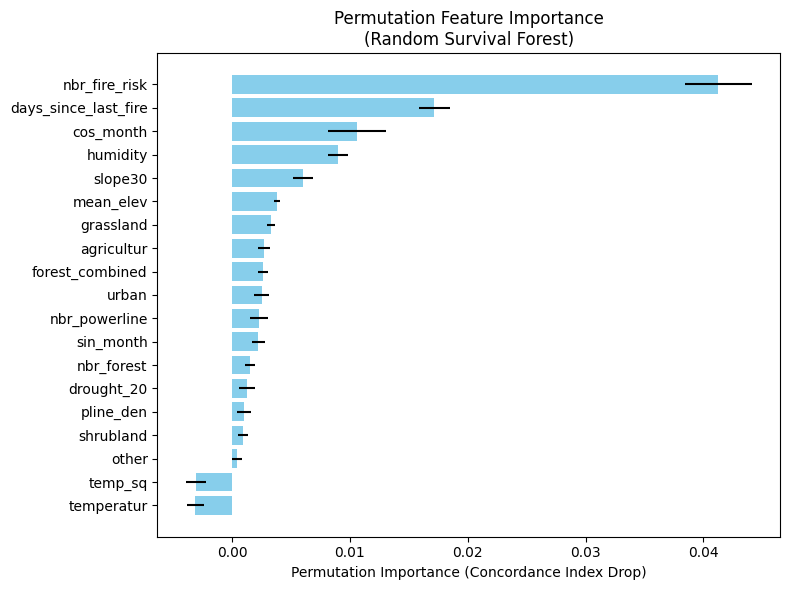

In [14]:
# nye feature
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
import numpy as np

from sksurv.metrics import concordance_index_censored

def concordance_scorer(model, X, y):
    surv_preds = model.predict(X)
    ci = concordance_index_censored(
        event_indicator=y["event"], 
        event_time=y["time"], 
        estimate=surv_preds
    )[0]  # Only take the first value (the concordance index itself)
    return ci


def plot_rsf_permutation_importance(model, X, y, feature_names, n_repeats=2, random_state=42):
    """
    Computes and plots permutation importance for RSF using concordance index.
    """
    result = permutation_importance(
        model,
        X,
        y,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=concordance_scorer
    )

    importances = result.importances_mean
    std = result.importances_std
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 6))
    plt.barh(np.array(feature_names)[sorted_idx][::-1],
             importances[sorted_idx][::-1],
             xerr=std[sorted_idx][::-1],
             color="skyblue")
    plt.xlabel("Permutation Importance (Concordance Index Drop)")
    plt.title("Permutation Feature Importance\n(Random Survival Forest)")
    plt.tight_layout()
    plt.show()
model = ensemble_rsf_models[1]["model"]



# 1) Grab the first fold’s training frame:
df0 = ensemble_rsf_models[1]["df_train"]  # this is the scaled df_tr you stored

# 2) Reconstruct X and y from it
X = df0[rsf_features]
y = Surv.from_arrays(
    event = df0["fire_occur"],
    time  = df0["duration"]
)

# 3) (Optional) Sub‐sample for speed
np.random.seed(1)
idx = np.random.choice(len(X), size=1000, replace=False)
X_sample = X.iloc[idx]
y_sample = y[idx]

# 4) Call your plotting helper
plot_rsf_permutation_importance(
    model=ensemble_rsf_models[0]["model"],
    X   = X_sample,
    y   = y_sample,
    feature_names = rsf_features,
    n_repeats     = 5,   # a few more repeats will stabilize the bars
    random_state  = 42
)



Survival range: 0.3773152573724695 → 0.9998823529411764
Hazard   range: 0.00011765397978160611 → 0.974674214524497


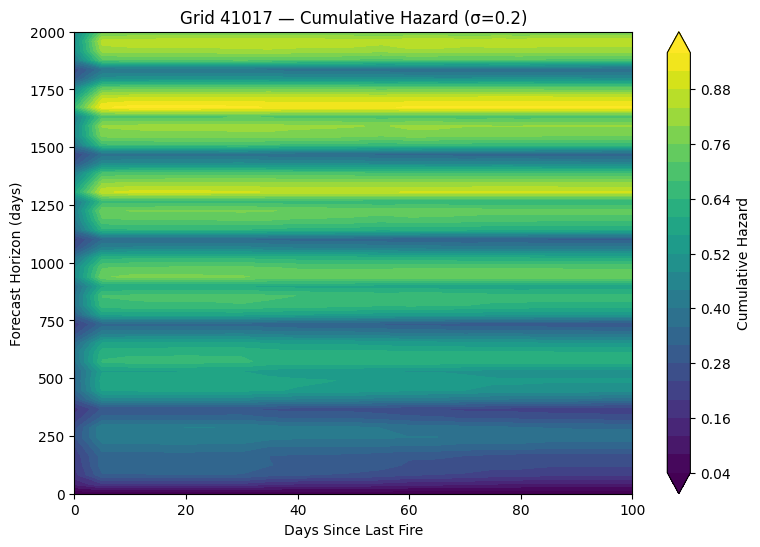

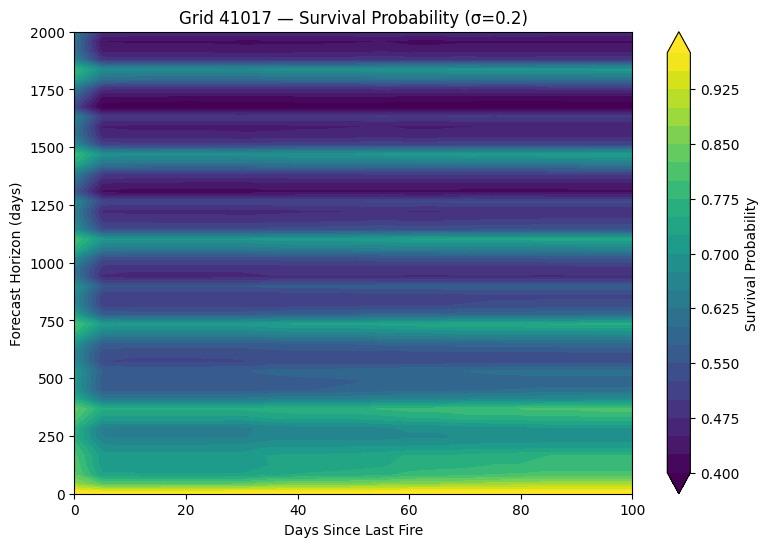

In [70]:
# mediterranian plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
def eval_sf_at(sf, t):
    t_max = sf.x[-1]
    if t <= t_max:
        return sf(t)
    else:
        return sf.y[-1]
def predict_and_plot_with_AG_ensemble(
    ensemble_models,
    event_df,
    df_monthly,
    grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.2
):
    # 1) Ranges
    days_since_fire_range = np.arange(0, 101, 5)

    # Build forecast_range as union of every model's unique_times_ support
    starts = [mdl["model"].unique_times_[0]  for mdl in ensemble_models]
    ends   = [mdl["model"].unique_times_[-1] for mdl in ensemble_models]
    t_min  = max(starts)
    t_max  = min(ends)
    forecast_range = np.linspace(0, 2000, 50)
    

    # 2) Prepare storage
    n_f = len(forecast_range)
    n_d = len(days_since_fire_range)
    survival_matrix = np.zeros((n_f, n_d))
    hazard_matrix   = np.zeros((n_f, n_d))

    # 3) Model features
    predictor_vars = [
    "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
    "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
    "cos_month", "temp_sq", "mean_elev", 
    "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other"
    ]

    # 4) Loop through grid of (forecast_time, days_since_fire)
    for i, t in enumerate(forecast_range):
        month = day_to_month(t % 365)
        monthly = get_monthly_values(df_monthly, grid_id, month, stat=statistic)

        for j, dsf in enumerate(days_since_fire_range):
            # Baseline row
            row = build_baseline_row(event_df, grid_id)
            row["days_since_last_fire"] = dsf
            c, s = compute_seasonality_cos_sin(t)
            row["cos_month"], row["sin_month"] = c, s
            row.update(monthly)

            # Ensure required static fields
            for var in ["pline_den","grassland","shrubland","agricultur",
                        "slope30","mean_elev","no_prior_fire","urban","other"]:
                row[var] = row.get(var, 0.0)

            # Predict for each fold
            survs = []
            for mdl in ensemble_models:
                rm = compute_neighbor_features(
                    row.copy(),
                    mdl["df_train_raw"],
                    mdl["coords_train"],
                    mdl["tree_train"],
                    neighbor_radius
                )
                rm["forest_combined"] = (rm["forest"] + rm["nbr_forest"]) / 2
                rm["road_combined"]   = (rm["road_den"] + rm["nbr_road"]) / 2

                X = pd.DataFrame([rm])
                Xs = X.copy()
                Xs[cols_to_scale] = mdl["scaler"].transform(X[cols_to_scale])
                Xs["temp_sq"] = Xs["temperatur"] ** 2

                Xf = Xs[predictor_vars]
                # get the list of survival‐function objects
                sf_list = mdl["model"].predict_survival_function(Xf)

                # evaluate the first one at your forecast time t
                sf = sf_list[0]
                surv_at_t = eval_sf_at(sf, t)

                survs.append(surv_at_t)


            avg = np.mean(survs)
            survival_matrix[i, j] = avg
            hazard_matrix[i, j]   = -np.log(avg) if avg > 0 else np.nan

    # 5) Debug ranges
    print("Survival range:", np.nanmin(survival_matrix), "→", np.nanmax(survival_matrix))
    print("Hazard   range:", np.nanmin(hazard_matrix),   "→", np.nanmax(hazard_matrix))

    # 6) Smooth
    surv_sm = gaussian_filter(survival_matrix, sigma=sigma)
    haz_sm  = gaussian_filter(hazard_matrix,   sigma=sigma)

    # 7) Plot
    Xg, Yg = np.meshgrid(days_since_fire_range, forecast_range)

    plt.figure(figsize=(9,6))
    cf = plt.contourf(Xg, Yg, haz_sm, levels=30, extend="both")
    plt.colorbar(cf, label="Cumulative Hazard")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Grid {grid_id} — Cumulative Hazard (σ={sigma})")
    plt.xlim(0, 100)
    plt.ylim(forecast_range.min(), forecast_range.max())
    plt.show()

    plt.figure(figsize=(9,6))
    cf2 = plt.contourf(Xg, Yg, surv_sm, levels=30, extend="both")
    plt.colorbar(cf2, label="Survival Probability")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Grid {grid_id} — Survival Probability (σ={sigma})")
    plt.xlim(0, 100)
    plt.ylim(forecast_range.min(), forecast_range.max())
    plt.show()


# Example usage:
grid_id = int(41017.0)
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y
gdf["centroid"]    = gdf.geometry.centroid

event_df = gdf.copy()

predict_and_plot_with_AG_ensemble(
    ensemble_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.2
)


C:\Users\hclt0\AppData\Local\Temp\ipykernel_31696\2715228977.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


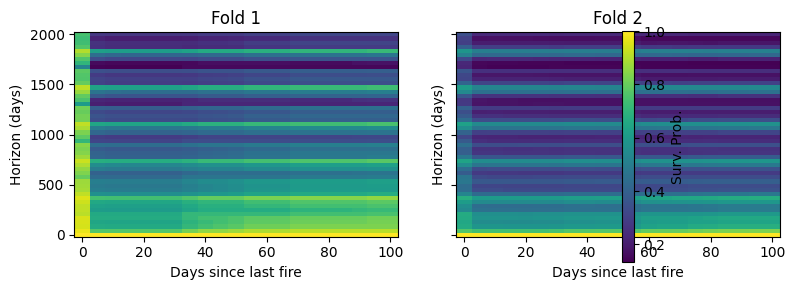

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def plot_individual_surfaces(
    ensemble_models,
    event_df,
    df_monthly,
    grid_id,
    statistic='median',
    neighbor_radius=10000,
    days_since_fire_range=None,
    forecast_range=None,
    sigma=0.2
):
    # defaults
    if days_since_fire_range is None:
        days_since_fire_range = np.arange(0, 101, 5)
    if forecast_range is None:
        forecast_range = np.linspace(0, 2000, 50)

    n_models = len(ensemble_models)
    n_cols = min(3, n_models)
    n_rows = int(np.ceil(n_models / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows),
                             sharex=True, sharey=True)
    axes = axes.flatten()

    for k, mdl in enumerate(ensemble_models):
        # prepare empty matrices
        surv_mat = np.zeros((len(forecast_range), len(days_since_fire_range)))

        # for each (t, dsf) get S_k(t | dsf)
        for i, t in enumerate(forecast_range):
            month = day_to_month(t % 365)
            monthly = get_monthly_values(df_monthly, grid_id, month, stat=statistic)
            for j, dsf in enumerate(days_since_fire_range):
                row = build_baseline_row(event_df, grid_id)
                row["days_since_last_fire"] = dsf
                c,s = compute_seasonality_cos_sin(t)
                row["cos_month"], row["sin_month"] = c,s
                row.update(monthly)

                # fill absent statics
                for var in ["pline_den","grassland","shrubland","agricultur",
                            "slope30","mean_elev","no_prior_fire","urban","other"]:
                    row[var] = row.get(var, 0.0)

                # neighbor feats + scale + QSQ
                rm = compute_neighbor_features(
                    row.copy(),
                    mdl["df_train_raw"],
                    mdl["coords_train"],
                    mdl["tree_train"],
                    neighbor_radius
                )
                rm["forest_combined"] = (rm["forest"] + rm["nbr_forest"])/2
                rm["temp_sq"]         = rm["temperatur"]**2

                X = pd.DataFrame([rm])
                X[ mdl["scaler"].feature_names_in_ ] = mdl["scaler"].transform(
                    X[ mdl["scaler"].feature_names_in_ ]
                )
                Xf = X[ mdl["model"].feature_names_in_ ]

                sf = mdl["model"].predict_survival_function(Xf)[0]
                surv_mat[i,j] = eval_sf_at(sf, t)

        # optionally smooth a little on DSF axis only
        surv_sm = gaussian_filter(surv_mat, sigma=(0,sigma))

        ax = axes[k]
        Xg, Yg = np.meshgrid(days_since_fire_range, forecast_range)
        pcm = ax.pcolormesh(Xg, Yg, surv_sm, shading='nearest', cmap='viridis')
        ax.set_title(f"Fold {k+1}")
        ax.set_xlabel("Days since last fire")
        ax.set_ylabel("Horizon (days)")

    # hide any unused panels
    for ax in axes[n_models:]:
        ax.axis("off")

    fig.colorbar(pcm, ax=axes.tolist(), label="Surv. Prob.")
    plt.tight_layout()
    plt.show()

grid_id = int(41017.0)
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y
gdf["centroid"]    = gdf.geometry.centroid

event_df = gdf.copy()

plot_individual_surfaces(
    ensemble_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.1
)


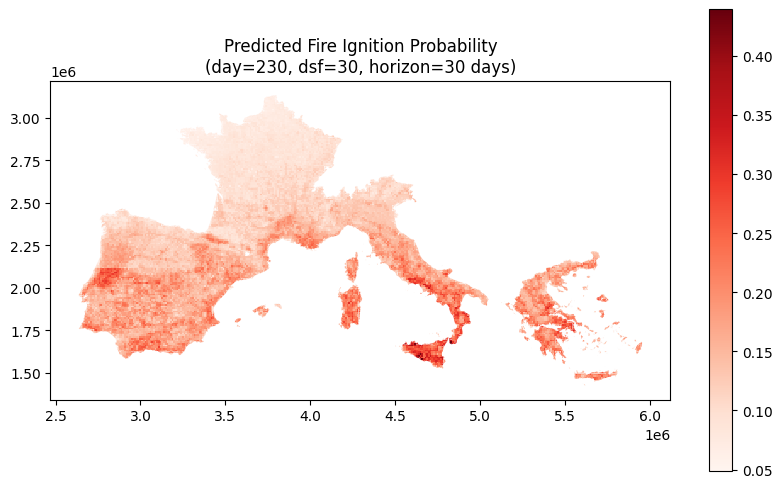

In [ ]:
# wherever you first define event_df
event_df = gpd.GeoDataFrame(event_df, geometry="geometry")
event_df["centroid"]    = event_df.geometry.centroid
event_df["centroid_x"]  = event_df.centroid.x
event_df["centroid_y"]  = event_df.centroid.y

def create_fire_probability_map(
    ensemble_rsf_models,
    event_df,
    df_monthly, 
    day_of_year=230,
    days_since_fire=30,
    forecast_horizon=30,
    neighbor_radius=10000,
    stat='median',
    sigma=0.0
):
    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry='geometry')

    gdf = event_df.drop_duplicates(subset='id').copy()

    first_model = ensemble_rsf_models[0]
    scaler = first_model["scaler"]
    df_train = first_model["df_train"]
    coords_train = first_model["coords_train"]
    tree_train = first_model["tree_train"]

    rsf_features = [
        "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
        "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "cos_month", "temp_sq", "mean_elev",
        "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    month = day_to_month(day_of_year)
    cos_month, sin_month = compute_seasonality_cos_sin(day_of_year)

    predicted_probs = []

    for _, row in gdf.iterrows():
        grid_id = row["id"]

        baseline = build_baseline_row(event_df, grid_id)
        monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat)
        scenario_row = baseline.copy()
        scenario_row.update(monthly_vars)
        scenario_row["days_since_last_fire"] = days_since_fire
        scenario_row["cos_month"] = cos_month
        scenario_row["sin_month"] = sin_month

        scenario_row = compute_neighbor_features(
            scenario_row, df_train, coords_train, tree_train, neighbor_radius
        )

        # Derived features
        scenario_row["forest_combined"] = (scenario_row["forest"] + scenario_row["nbr_forest"]) / 2
        scenario_row["temp_sq"] = scenario_row["temperatur"] ** 2

        # Scale + transform
        X_temp = pd.DataFrame([scenario_row])
        X_scaled = pd.DataFrame(
            scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale
        )
        X_final = pd.concat(
            [X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1
        )
        X_final = X_final[rsf_features]

        surv_probs = [
            m["model"].predict_survival_function(X_final)[0](forecast_horizon)
            for m in ensemble_rsf_models
        ]
        ignition_prob = 1.0 - np.mean(surv_probs)
        predicted_probs.append(ignition_prob)

    gdf["predicted_prob"] = predicted_probs

    if sigma > 0:
        pass  # optional smoothing step

    return gdf


gdf_map = create_fire_probability_map(
    ensemble_rsf_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat='median',
    sigma=0.0
)
fig, ax = plt.subplots(figsize=(10, 6))
gdf_map.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax)
ax.set_title("Predicted Fire Ignition Probability\n(day=230, dsf=30, horizon=30 days)")
plt.show()

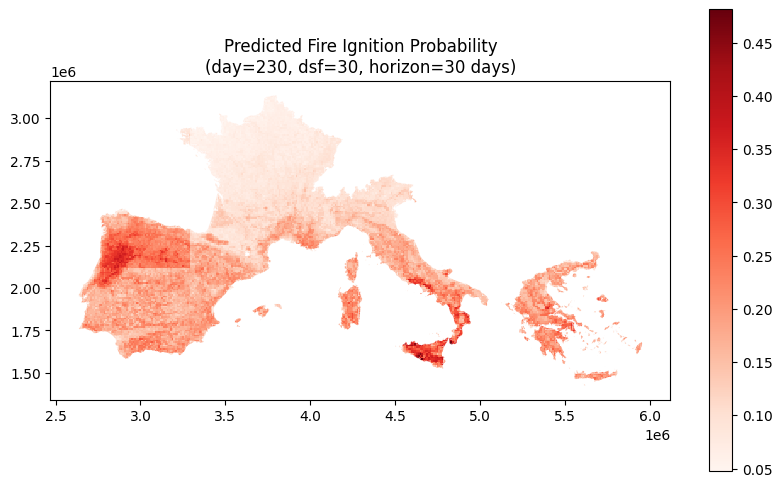

In [ ]:
# wherever you first define event_df
event_df = gpd.GeoDataFrame(event_df, geometry="geometry")
event_df["centroid"]    = event_df.geometry.centroid
event_df["centroid_x"]  = event_df.centroid.x
event_df["centroid_y"]  = event_df.centroid.y

def create_fire_probability_map(
    ensemble_rsf_models,
    event_df,
    df_monthly, 
    day_of_year=230,
    days_since_fire=30,
    forecast_horizon=30,
    neighbor_radius=10000,
    stat='median',
    sigma=0.0
):
    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry='geometry')

    gdf = event_df.drop_duplicates(subset='id').copy()

    first_model = ensemble_rsf_models[0]
    scaler = first_model["scaler"]
    df_train = first_model["df_train"]
    coords_train = first_model["coords_train"]
    tree_train = first_model["tree_train"]

    rsf_features = [
        "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
        "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "cos_month", "temp_sq", "mean_elev",
        "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    month = day_to_month(day_of_year)
    cos_month, sin_month = compute_seasonality_cos_sin(day_of_year)

    predicted_probs = []

    for _, row in gdf.iterrows():
        grid_id = row["id"]

        baseline = build_baseline_row(event_df, grid_id)
        monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat)
        scenario_row = baseline.copy()
        scenario_row.update(monthly_vars)
        scenario_row["days_since_last_fire"] = days_since_fire
        scenario_row["cos_month"] = cos_month
        scenario_row["sin_month"] = sin_month

        scenario_row = compute_neighbor_features(
            scenario_row, df_train, coords_train, tree_train, neighbor_radius
        )

        # Derived features
        scenario_row["forest_combined"] = (scenario_row["forest"] + scenario_row["nbr_forest"]) / 2
        scenario_row["temp_sq"] = scenario_row["temperatur"] ** 2

        # Scale + transform
        X_temp = pd.DataFrame([scenario_row])
        X_scaled = pd.DataFrame(
            scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale
        )
        X_final = pd.concat(
            [X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1
        )
        X_final = X_final[rsf_features]

        surv_probs = [
            m["model"].predict_survival_function(X_final)[0](forecast_horizon)
            for m in ensemble_rsf_models
        ]
        ignition_prob = 1.0 - np.mean(surv_probs)
        predicted_probs.append(ignition_prob)

    gdf["predicted_prob"] = predicted_probs

    if sigma > 0:
        pass  # optional smoothing step

    return gdf


gdf_map = create_fire_probability_map(
    ensemble_rsf_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat='median',
    sigma=0.0
)
fig, ax = plt.subplots(figsize=(10, 6))
gdf_map.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax)
ax.set_title("Predicted Fire Ignition Probability\n(day=230, dsf=60, horizon=100 days)")
plt.show()

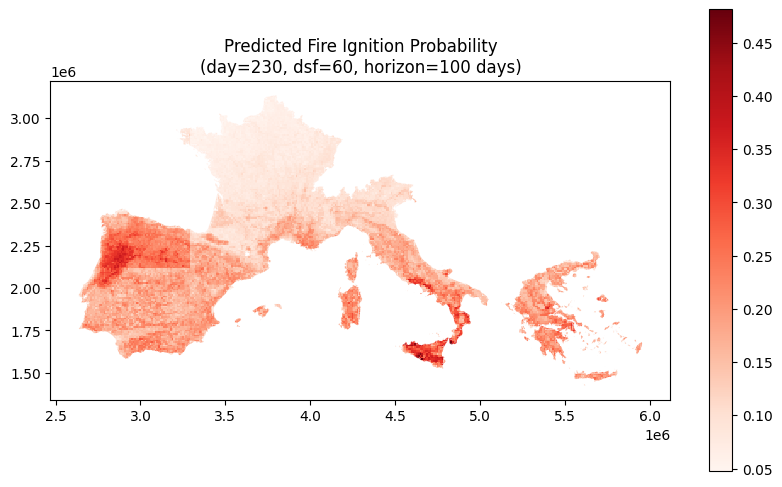

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
gdf_map.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax)
ax.set_title("Predicted Fire Ignition Probability\n(day=230, dsf=60, horizon=100 days)")
plt.show()

In [21]:
num_fires = int(event_df["fire_occur"].sum())
print(f"Number of fire occurrences: {num_fires}")


Number of fire occurrences: 16828


In [28]:
def get_monthly_values(df_monthly, grid_id, month, stat_dict=None):
    """
    Retrieves values for temperature, humidity, drought20, wind_speed using stat_dict.

    Parameters:
        df_monthly: DataFrame with columns like 'temperature_q75', etc.
        grid_id: grid cell ID
        month: 1-based month index (1–12)
        stat_dict: dict like {'temperatur': 'q75', 'humidity': 'q25', 'drought_20': 'q25'}

    Returns:
        Dictionary of values for use in model input
    """
    if stat_dict is None:
        stat_dict = {}

    row = df_monthly[(df_monthly["id"] == grid_id) & (df_monthly["month"] == month)]
    if row.empty:
        raise ValueError(f"No monthly data for grid_id={grid_id}, month={month}")
    row = row.iloc[0]

    def get_value(base, alias=None):
        var_key = alias or base
        stat = stat_dict.get(var_key, "median")
        col = f"{base}_{stat}"
        if col not in row:
            raise KeyError(f"Column {col} not found in df_monthly")
        return row[col]

    return {
        "temperatur":   get_value("temperature"),                 # maps to 'temperatur' in model
        "wind_speed":   get_value("wind_speed"),
        "drought_20":   get_value("drought20", "drought_20"),     # alias ensures key matching
        "humidity":     get_value("humidity"),
    }


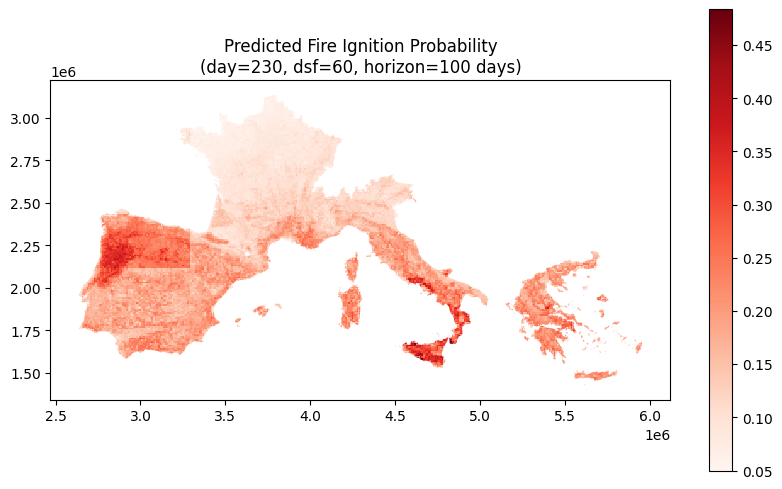

In [26]:
# wherever you first define event_df
event_df = gpd.GeoDataFrame(event_df, geometry="geometry")
event_df["centroid"]    = event_df.geometry.centroid
event_df["centroid_x"]  = event_df.centroid.x
event_df["centroid_y"]  = event_df.centroid.y

def create_fire_probability_map(
    ensemble_rsf_models,
    event_df,
    df_monthly, 
    day_of_year=230,
    days_since_fire=30,
    forecast_horizon=30,
    neighbor_radius=10000,
    stat_dict=None,
    sigma=0.0
):
    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry='geometry')

    gdf = event_df.drop_duplicates(subset='id').copy()

    first_model = ensemble_rsf_models[0]
    scaler = first_model["scaler"]
    df_train = first_model["df_train"]
    coords_train = first_model["coords_train"]
    tree_train = first_model["tree_train"]

    rsf_features = [
        "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
        "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "cos_month", "temp_sq", "mean_elev",
        "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    month = day_to_month(day_of_year)
    cos_month, sin_month = compute_seasonality_cos_sin(day_of_year)

    predicted_probs = []

    for _, row in gdf.iterrows():
        grid_id = row["id"]

        baseline = build_baseline_row(event_df, grid_id)
        monthly_stat_dict = stat_dict or {
            "temperatur": "median",
            "humidity": "median",
            "drought_20": "median",
            "wind_speed": "median"
        }
        monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=monthly_stat_dict)

        scenario_row = baseline.copy()
        scenario_row.update(monthly_vars)
        scenario_row["days_since_last_fire"] = days_since_fire
        scenario_row["cos_month"] = cos_month
        scenario_row["sin_month"] = sin_month

        scenario_row = compute_neighbor_features(
            scenario_row, df_train, coords_train, tree_train, neighbor_radius
        )

        # Derived features
        scenario_row["forest_combined"] = (scenario_row["forest"] + scenario_row["nbr_forest"]) / 2
        scenario_row["temp_sq"] = scenario_row["temperatur"] ** 2

        # Scale + transform
        X_temp = pd.DataFrame([scenario_row])
        X_scaled = pd.DataFrame(
            scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale
        )
        X_final = pd.concat(
            [X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1
        )
        X_final = X_final[rsf_features]

        surv_probs = [
            m["model"].predict_survival_function(X_final)[0](forecast_horizon)
            for m in ensemble_rsf_models
        ]
        ignition_prob = 1.0 - np.mean(surv_probs)
        predicted_probs.append(ignition_prob)

    gdf["predicted_prob"] = predicted_probs

    if sigma > 0:
        pass  # optional smoothing step

    return gdf


gdf_map = create_fire_probability_map(
    ensemble_rsf_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat_dict={
        "temperatur": "q75",
        "humidity": "q25",
        "drought_20": "q25"
    },
    sigma=0.0
)
fig, ax = plt.subplots(figsize=(10, 6))
gdf_map.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax)
ax.set_title("Predicted Fire Ignition Probability\n(day=230, dsf=60, horizon=100 days)")
plt.show()

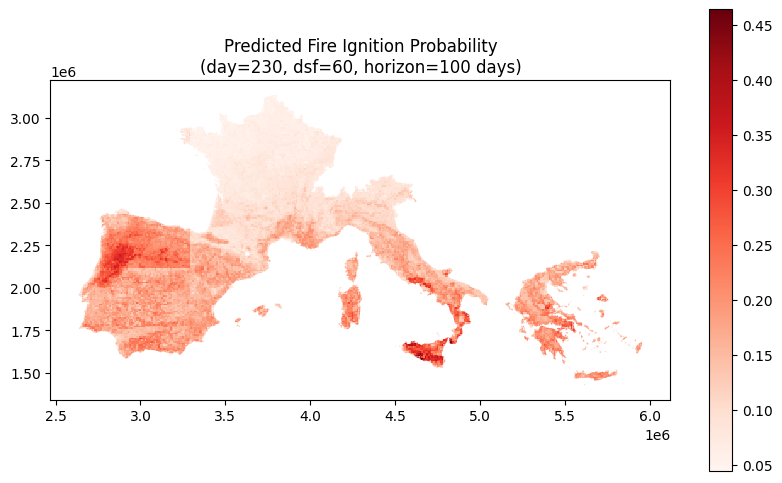

In [31]:
# wherever you first define event_df
event_df = gpd.GeoDataFrame(event_df, geometry="geometry")
event_df["centroid"]    = event_df.geometry.centroid
event_df["centroid_x"]  = event_df.centroid.x
event_df["centroid_y"]  = event_df.centroid.y

def create_fire_probability_map(
    ensemble_rsf_models,
    event_df,
    df_monthly, 
    day_of_year=230,
    days_since_fire=30,
    forecast_horizon=30,
    neighbor_radius=10000,
    stat_dict=None,
    sigma=0.0
):
    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry='geometry')

    gdf = event_df.drop_duplicates(subset='id').copy()

    first_model = ensemble_rsf_models[0]
    scaler = first_model["scaler"]
    df_train = first_model["df_train"]
    coords_train = first_model["coords_train"]
    tree_train = first_model["tree_train"]

    rsf_features = [
        "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
        "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "cos_month", "temp_sq", "mean_elev",
        "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    month = day_to_month(day_of_year)
    cos_month, sin_month = compute_seasonality_cos_sin(day_of_year)

    predicted_probs = []

    for _, row in gdf.iterrows():
        grid_id = row["id"]

        baseline = build_baseline_row(event_df, grid_id)
        monthly_stat_dict = stat_dict or {
            "temperatur": "median",
            "humidity": "median",
            "drought_20": "median",
            "wind_speed": "median"
        }
        monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=monthly_stat_dict)

        scenario_row = baseline.copy()
        scenario_row.update(monthly_vars)
        scenario_row["days_since_last_fire"] = days_since_fire
        scenario_row["cos_month"] = cos_month
        scenario_row["sin_month"] = sin_month

        scenario_row = compute_neighbor_features(
            scenario_row, df_train, coords_train, tree_train, neighbor_radius
        )

        # Derived features
        scenario_row["forest_combined"] = (scenario_row["forest"] + scenario_row["nbr_forest"]) / 2
        scenario_row["temp_sq"] = scenario_row["temperatur"] ** 2

        # Scale + transform
        X_temp = pd.DataFrame([scenario_row])
        X_scaled = pd.DataFrame(
            scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale
        )
        X_final = pd.concat(
            [X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1
        )
        X_final = X_final[rsf_features]

        surv_probs = [
            m["model"].predict_survival_function(X_final)[0](forecast_horizon)
            for m in ensemble_rsf_models
        ]
        ignition_prob = 1.0 - np.mean(surv_probs)
        predicted_probs.append(ignition_prob)

    gdf["predicted_prob"] = predicted_probs

    if sigma > 0:
        pass  # optional smoothing step

    return gdf


gdf_map = create_fire_probability_map(
    ensemble_rsf_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat_dict={
        "temperatur": "q25",
        "humidity": "q75",
        "drought_20": "q75"
    },
    sigma=0.0
)
fig, ax = plt.subplots(figsize=(10, 6))
gdf_map.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax)
ax.set_title("Predicted Fire Ignition Probability\n(day=230, dsf=60, horizon=100 days)")
plt.show()

In [27]:
df_monthly.columns

Index(['id', 'month', 'temperature_mean', 'temperature_median',
       'temperature_q25', 'temperature_q75', 'wind_speed_mean',
       'wind_speed_median', 'wind_speed_q25', 'wind_speed_q75',
       'drought20_mean', 'drought20_median', 'drought20_q25', 'drought20_q75',
       'humidity_mean', 'humidity_median', 'humidity_q25', 'humidity_q75'],
      dtype='object')

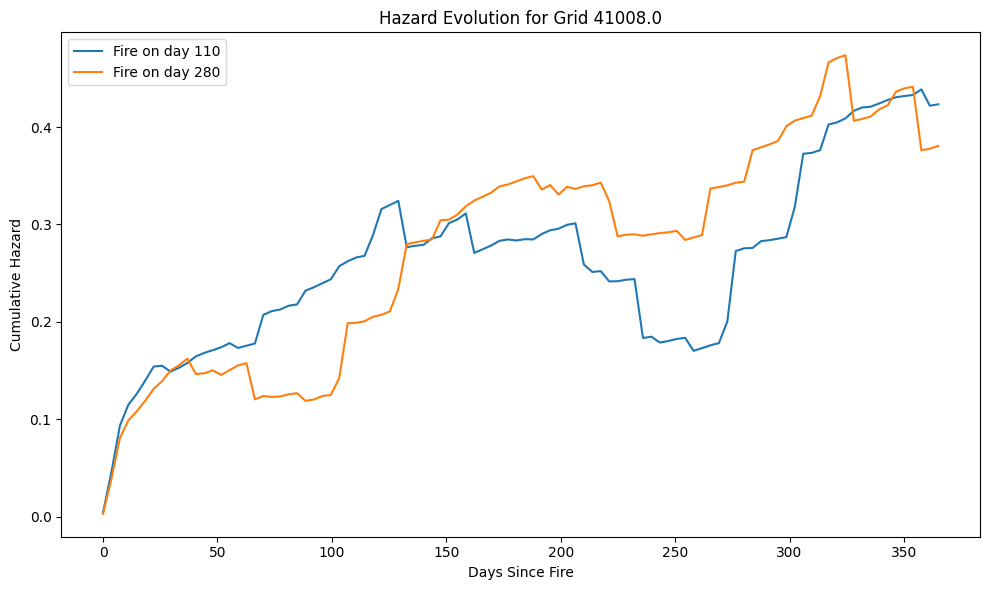

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_fire_timing_effect(
    ensemble_rsf_models,
    event_df,
    df_monthly,
    grid_id,
    initial_day_values=[120, 300],
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    statistic='median'
):
    """
    Compare cumulative hazard over time for different fire start days
    at a specific grid cell, using your RSF ensemble.
    """

    rsf_features = [
        "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
        "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "cos_month", "temp_sq", "mean_elev", 
        "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    forecast_times = np.linspace(0, forecast_horizon, 100)
    results = {}

    # Pull required components from first model
    model_obj = ensemble_rsf_models[0]
    df_train = model_obj["df_train"]
    coords_train = model_obj["coords_train"]
    tree_train = model_obj["tree_train"]
    scaler = model_obj["scaler"]

    baseline = build_baseline_row(event_df, grid_id)

    for init_day in initial_day_values:
        hazard_curve = []
        for t in forecast_times:
            day_t = (init_day + t) % 365
            month = day_to_month(day_t)
            cos_month, sin_month = compute_seasonality_cos_sin(day_t)
            monthly_stat_dict = {
                "temperatur": "q25",
                "humidity": "q75",
                "drought_20": "q75",
                "wind_speed": statistic  # optional; use median or something consistent
            }
            monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=monthly_stat_dict)


            row = baseline.copy()
            row.update(monthly_vars)

            row["days_since_last_fire"] = days_since_fire
            row["cos_month"] = cos_month
            row["sin_month"] = sin_month

            row = compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius)

            # Derived features
            row["forest_combined"] = (row["forest"] + row["nbr_forest"]) / 2
            row["temp_sq"] = row["temperatur"] ** 2

            # Make sure all features are present
            for feature in rsf_features:
                if feature not in row:
                    row[feature] = 0.0

            X_temp = pd.DataFrame([row])
            X_scaled = pd.DataFrame(scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale)
            X_final = pd.concat([X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1)
            X_final = X_final[rsf_features]

            # Predict survival
            surv_probs = []
            for m in ensemble_rsf_models:
                surv_func = m["model"].predict_survival_function(X_final)[0]
                clamped_time = min(t, surv_func.x[-1])
                surv_probs.append(surv_func(clamped_time))

            surv_prob = np.mean(surv_probs)
            surv_prob_safe = np.clip(surv_prob, 1e-6, 1.0)
            hazard = -np.log(surv_prob_safe)
            hazard_curve.append(hazard)

        results[init_day] = hazard_curve

    # Plotting
    plt.figure(figsize=(10, 6))
    for init_day, hazard_curve in results.items():
        plt.plot(forecast_times, hazard_curve, label=f"Fire on day {init_day}")
    plt.xlabel("Days Since Fire")
    plt.ylabel("Cumulative Hazard")
    plt.title(f"Hazard Evolution for Grid {grid_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_fire_timing_effect(
    ensemble_rsf_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=41008.0,
    initial_day_values=[110, 280],  # e.g., May and October
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    statistic='median'
)


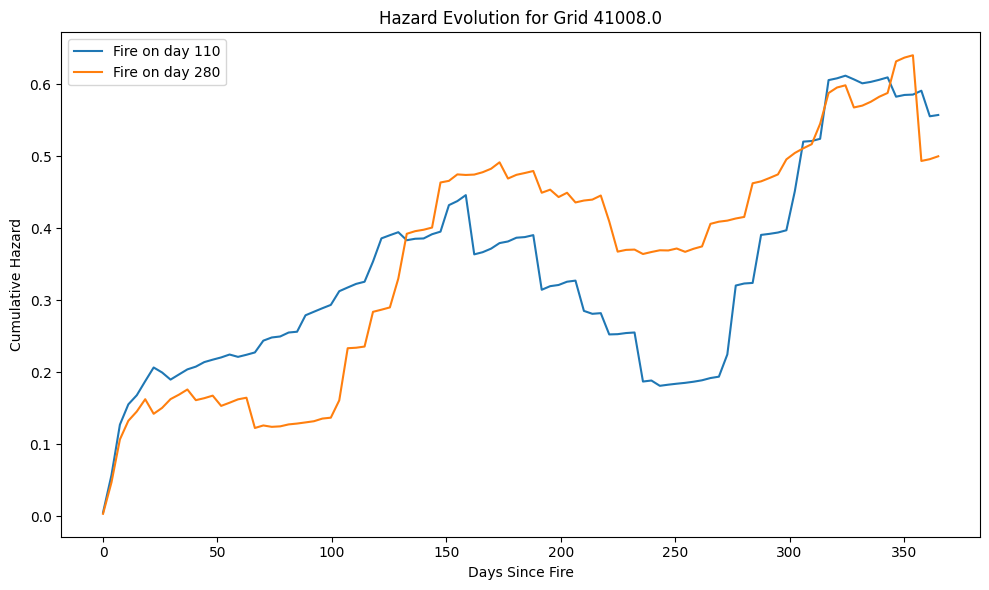

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_fire_timing_effect(
    ensemble_rsf_models,
    event_df,
    df_monthly,
    grid_id,
    initial_day_values=[120, 300],
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    statistic='median'
):
    """
    Compare cumulative hazard over time for different fire start days
    at a specific grid cell, using your RSF ensemble.
    """

    rsf_features = [
        "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
        "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "cos_month", "temp_sq", "mean_elev", 
        "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    forecast_times = np.linspace(0, forecast_horizon, 100)
    results = {}

    # Pull required components from first model
    model_obj = ensemble_rsf_models[0]
    df_train = model_obj["df_train"]
    coords_train = model_obj["coords_train"]
    tree_train = model_obj["tree_train"]
    scaler = model_obj["scaler"]

    baseline = build_baseline_row(event_df, grid_id)

    for init_day in initial_day_values:
        hazard_curve = []
        for t in forecast_times:
            day_t = (init_day + t) % 365
            month = day_to_month(day_t)
            cos_month, sin_month = compute_seasonality_cos_sin(day_t)
            monthly_stat_dict = {
                "temperatur": "q75",
                "humidity": "q25",
                "drought_20": "q25",
                "wind_speed": statistic  # optional; use median or something consistent
            }
            monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=monthly_stat_dict)


            row = baseline.copy()
            row.update(monthly_vars)

            row["days_since_last_fire"] = days_since_fire
            row["cos_month"] = cos_month
            row["sin_month"] = sin_month

            row = compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius)

            # Derived features
            row["forest_combined"] = (row["forest"] + row["nbr_forest"]) / 2
            row["temp_sq"] = row["temperatur"] ** 2

            # Make sure all features are present
            for feature in rsf_features:
                if feature not in row:
                    row[feature] = 0.0

            X_temp = pd.DataFrame([row])
            X_scaled = pd.DataFrame(scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale)
            X_final = pd.concat([X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1)
            X_final = X_final[rsf_features]

            # Predict survival
            surv_probs = []
            for m in ensemble_rsf_models:
                surv_func = m["model"].predict_survival_function(X_final)[0]
                clamped_time = min(t, surv_func.x[-1])
                surv_probs.append(surv_func(clamped_time))

            surv_prob = np.mean(surv_probs)
            surv_prob_safe = np.clip(surv_prob, 1e-6, 1.0)
            hazard = -np.log(surv_prob_safe)
            hazard_curve.append(hazard)

        results[init_day] = hazard_curve

    # Plotting
    plt.figure(figsize=(10, 6))
    for init_day, hazard_curve in results.items():
        plt.plot(forecast_times, hazard_curve, label=f"Fire on day {init_day}")
    plt.xlabel("Days Since Fire")
    plt.ylabel("Cumulative Hazard")
    plt.title(f"Hazard Evolution for Grid {grid_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_fire_timing_effect(
    ensemble_rsf_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=41008.0,
    initial_day_values=[110, 280],  # e.g., May and October
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    statistic='median'
)


In [13]:
import numpy as np
from scipy.stats import shapiro, ttest_rel, wilcoxon

# Five test‐fold C‐indices for each model
ag_test  = np.array([0.703, 0.856, 0.766, 0.821, 0.927, 0.788])
rsf_test = np.array([0.7219, 0.9064, 0.8494, 0.8948, 0.9609, 0.8598])

# 1) Compute paired differences
diff_rsf_ag = rsf_test - ag_test

# 2) Shapiro–Wilk test for normality of the differences
w_stat, w_p = shapiro(diff_rsf_ag)

# 3) Paired t-test
t_stat, t_p = ttest_rel(rsf_test, ag_test)

# 4) Wilcoxon signed-rank test (two-sided)
wlk_stat, wlk_p = wilcoxon(rsf_test, ag_test)

print("RSF vs AG (Campania spatial split):")
print(f"  Shapiro–Wilk: W = {w_stat:.3f}, p = {w_p:.3f}")
print(f"  Paired t-test: t = {t_stat:.3f}, p = {t_p:.4f}")
print(f"  Wilcoxon:     W = {wlk_stat}, p = {wlk_p:.4f}")


RSF vs AG (Campania spatial split):
  Shapiro–Wilk: W = 0.927, p = 0.558
  Paired t-test: t = 5.352, p = 0.0031
  Wilcoxon:     W = 0.0, p = 0.0312


In [11]:
import numpy as np
from sksurv.metrics import concordance_index_censored

def bootstrap_delta(ci_model_a, ci_model_b, n_boot=10000):
    ci_a = np.array(ci_model_a)
    ci_b = np.array(ci_model_b)
    diffs = ci_a - ci_b
    boot_means = []
    for _ in range(n_boot):
        sample = np.random.choice(diffs, size=len(diffs), replace=True)
        boot_means.append(sample.mean())
    lo, hi = np.percentile(boot_means, [2.5, 97.5])
    return diffs.mean(), lo, hi

# your 5‐fold test C-indices:
ag_test  = [0.703, 0.856, 0.766, 0.821, 0.927, 0.788]
rsf_test = [0.7219, 0.9064, 0.8494, 0.8948, 0.9609, 0.8598]

mean_delta, lo, hi = bootstrap_delta(rsf_test, ag_test, n_boot=10000)
print(f"RSF – AG: ΔC = {mean_delta:.3f}, 95% CI = [{lo:.3f}, {hi:.3f}]")


RSF – AG: ΔC = 0.055, 95% CI = [0.036, 0.073]


## Deep.Surv